In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 8

GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1

DIS_IN_CHANNELS = 1
DIS_N_CLASSES = 2

E_IN_CHANNELS = 1
E_N_CLASSES = 2

EPOCH = 200

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = "scse"

#### head

In [7]:
GEN_ACT = "sigmoid"
DIS_ACT = "softmax"
E_ACT = "softmax"

### Optimizer Settings

In [8]:
GEN_OPTIM_NAME = "adam"
GEN_init_lr = 1e-4
GEN_momentum = 0.9

In [9]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 1e-3
DIS_momentum = 0.9
DIS_scheduler = "cosineAnnWarm"

In [10]:
E_OPTIM_NAME = "adam"
E_init_lr = 1e-3
E_momentum = 0.9
E_scheduler = "cosineAnnWarm"

# Epochs

In [11]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR, ContourEval
from codes.activation import Activation
from codes.utils import hu_clip_tensor
from codes.losses import PerceptualLoss
from kornia.filters.sobel import Sobel

In [12]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [13]:
def replace_relu_to_leakyReLU(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, nn.LeakyReLU())
        else:
            replace_relu_to_leakyReLU(child)

In [14]:
def replace_bn_to_instanceNorm(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.BatchNorm2d):
            bn = getattr(model, child_name)
            setattr(model, child_name, nn.InstanceNorm2d(bn.num_features))
        else:
            replace_bn_to_instanceNorm(child)

In [15]:
perceptual_ext = PerceptualLoss()

In [16]:
sobel_filter = Sobel().to(device)

In [17]:
def train_a2b_epoch(epoch, generator, gen_optim, 
                    tf_discriminator, tf_d_optim, tf_scheduler, 
                    edge_discriminator, edge_d_optim, edge_scheduler, 
                    dataloader, device):

    # change mode to train and move to current device
    generator = generator.eval().to(device)
    tf_discriminator = tf_discriminator.train().to(device)
    edge_discriminator = edge_discriminator.train().to(device)
    
    tf_dis_l = 0
    edge_dis_l = 0
    tf_gen_l = 0
    edge_gen_l = 0

    set_requires_grad(tf_discriminator, True)
    set_requires_grad(edge_discriminator, True)
    set_requires_grad(generator, False)
    
    iteration = len(dataloader)
    
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
       ############################
        # (1) Update True/Fake D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        tf_d_optim.zero_grad()

        y_cls = tf_discriminator(y)
        y_pr_cls = tf_discriminator(y_pr.detach())
        
        tf_dis = 0
        for _y_cls, _y_pr_cls in zip(y_cls, y_pr_cls):
            B, C, H, W = _y_cls.size()
            tf_dis = nn.CrossEntropyLoss()(_y_cls.float(), torch.zeros((B, H, W), dtype=torch.long, device=device)) + \
                                    nn.CrossEntropyLoss()(_y_pr_cls.float(), torch.ones((B, H, W), dtype=torch.long, device=device)) + \
                                    tf_dis

        tf_dis = tf_dis / (len(y_cls))
        tf_dis.backward()
        tf_d_optim.step()
        tf_scheduler.step(epoch + index / iteration)
        
        tf_dis_l += tf_dis.item()
        
       ############################
        # (1.1) Update Edge D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################        
        edge_d_optim.zero_grad()        
 
        edge_y_cls = edge_discriminator(edge_y)
        edge_pr_cls = edge_discriminator(edge_y_pr.detach())
        
        edge_dis = 0
        for _edge_y_cls, _edge_pr_cls in zip(edge_y_cls, edge_pr_cls):
            B, C, H, W = _edge_y_cls.size()
            edge_dis = nn.CrossEntropyLoss()(_edge_y_cls.float(), torch.zeros((B, H, W), dtype=torch.long, device=device)) + \
                                    nn.CrossEntropyLoss()(_edge_pr_cls.float(), torch.ones((B, H, W), dtype=torch.long, device=device)) + \
                                    edge_dis

        edge_dis = edge_dis / (len(edge_y_cls))
        edge_dis.backward()
        edge_d_optim.step()       
        edge_scheduler.step(epoch + index / iteration)

        edge_dis_l += edge_dis.item()

        
    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    
    # change mode to train and move to current device
    generator = generator.train().to(device)
    tf_discriminator = tf_discriminator.eval().to(device)
    edge_discriminator = edge_discriminator.eval().to(device)
    
    air_l = 0
    bone_l = 0
    
    set_requires_grad(tf_discriminator, False)
    set_requires_grad(edge_discriminator, False)
    set_requires_grad(generator, True)
        
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)

        gen_optim.zero_grad()

        # adversarial loss
        assert y_pr.requires_grad, "ct_pred without gradient"
        assert edge_y_pr.requires_grad, "edge without gradient"
        
        y_pr_cls = tf_discriminator(y_pr)
        tf_gen = 0
        for _y_pr_cls in y_pr_cls:
            B, C, H, W = _y_pr_cls.size()
            tf_gen = nn.CrossEntropyLoss()(_y_pr_cls.float(), torch.zeros((B, H, W), dtype=torch.long, device=device)) + tf_gen
        tf_gen = tf_gen / (len(y_pr_cls))
        
        edge_pr_cls = edge_discriminator(edge_y_pr)  
        edge_gen = 0
        for _edge_pr_cls in edge_pr_cls:
            B, C, H, W = _edge_pr_cls.size()
            edge_gen = nn.CrossEntropyLoss()(_edge_pr_cls.float(), torch.zeros((B, H, W), dtype=torch.long, device=device)) + edge_gen
        edge_gen = edge_gen / (len(edge_pr_cls))
        
        # auxilary loss
        # https://discuss.pytorch.org/t/unclear-about-weighted-bce-loss/21486/2
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        bone_loss = nn.BCELoss()(bone_pr.float(), bone_x.float())

        _loss = tf_gen + edge_gen + air_loss + bone_loss
        _loss.backward()    
        gen_optim.step()

        edge_gen_l += edge_gen.item()
        tf_gen_l += tf_gen.item()
        air_l += air_loss.item()
        bone_l += bone_loss.item()
        
    return  air_l/(index+1), bone_l/(index+1), \
                    edge_gen_l/(index+1), tf_gen_l/(index+1), \
                    edge_dis_l/(index+1), tf_dis_l/(index+1), \
                    tf_scheduler.get_last_lr()[0], edge_scheduler.get_last_lr()[0]

In [18]:
@torch.no_grad()
def eval_epoch(generator, tf_discriminator, edge_discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    tf_discriminator = tf_discriminator.eval().to(device)
    edge_discriminator = edge_discriminator.eval().to(device)
    
    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    
    air_ = []
    bone_ = []
    cont_ = []
 
    tf_acc = []
    edge_acc = []
    
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        
       ############################
        # (1) Eval True/Fake D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################        
        y_cls = tf_discriminator(y)
        for _y_cls in y_cls:
            B, C, H, W = _y_cls.size()
            total = H * W
            _y_cls = Activation(name=DIS_ACT)(_y_cls)
            _, _y_cls = torch.max(_y_cls.data, 1)
            correct = (_y_cls == torch.zeros((B, H, W), dtype=torch.long, device=device)).sum().item()
            tf_acc += [correct / total]        
        
        y_pr_cls = tf_discriminator(y_pr)
        for _y_pr_cls in y_pr_cls:
            B, C, H, W = _y_pr_cls.size()
            total = H * W
            _y_pr_cls = Activation(name=DIS_ACT)(_y_pr_cls)
            _, _y_pr_cls = torch.max(_y_pr_cls.data, 1)
            correct = (_y_pr_cls == torch.ones((B, H, W), dtype=torch.long, device=device)).sum().item()
            tf_acc += [correct / total]
        
       ############################
        # (1.1) Eval Edge D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################  
        edge_y_cls = edge_discriminator(edge_y)
        for _edge_y_cls in edge_y_cls:
            B, C, H, W = _edge_y_cls.size()
            total = H * W
            _edge_y_cls = Activation(name=DIS_ACT)(_edge_y_cls)
            _, _edge_y_cls = torch.max(_edge_y_cls.data, 1)
            correct = (_edge_y_cls == torch.zeros((B, H, W), dtype=torch.long, device=device)).sum().item()
            edge_acc += [correct / total]          
        
        edge_pr_cls = edge_discriminator(edge_y_pr)
        for _edge_pr_cls in edge_pr_cls:
            B, C, H, W = _edge_pr_cls.size()
            total = H * W
            _edge_pr_cls = Activation(name=DIS_ACT)(_edge_pr_cls)
            _, _edge_pr_cls = torch.max(_edge_pr_cls.data, 1)
            correct = (_edge_pr_cls == torch.ones((B, H, W), dtype=torch.long, device=device)).sum().item()
            edge_acc += [correct / total]        
        
        ############################
        # (2) Eval G network: maximize log(D(G(z)))
        ###########################
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]

        for b in range(x.size()[0]):
            cont = ContourEval()(y_pr[b, :, :, :], x[b, :, :, :])
            cont_ += [cont.item()]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(cont_)/len(cont_), sum(tf_acc)/len(tf_acc), sum(edge_acc)/len(edge_acc)

In [19]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)
    
    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)

        for b in range(x.shape[0]):           
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            _cont = ContourEval()(tmp_y_pr, x[b, :, :, :])
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            print("contour dice score = {}".format(_cont.item()))
            
            __cbct = (x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_masked = __ct_pred * tmp_air.squeeze().cpu().numpy()
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_pr = (edge_y_pr[b, :].squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_x = (edge_x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_y = (edge_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                edge_pred = __edge_pr,
                edge_x = __edge_x,
                edge_y = __edge_y,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_pred.jpg"), __edge_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_cbct.jpg"), __edge_x)
                cv2.imwrite(os.path.join(path_dir, "edge_ct.jpg"), __edge_y)
                
            iid += 1

# Discriminator

In [20]:
from codes.activation import Activation
import torchvision.models as models
from codes.losses import MultiScalePatchHeads

In [21]:
class Discriminator(nn.Module):
    def __init__(self, in_channel=1, n_classes=2, activation=None):
        
        super(Discriminator, self).__init__()
        
        encoder = smp.Unet(encoder_name="resnet18", in_channels=in_channel, classes=n_classes).encoder
        self.encoder = encoder
        self.fc = MultiScalePatchHeads(n_classes=n_classes, channels=(512, ), activation=None)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.fc([x[-1]])
        return x

# Generator

In [22]:
import segmentation_models_pytorch as smp
from codes.decoder import UnetDecoder
from segmentation_models_pytorch.base.heads import SegmentationHead

In [23]:
class Generator(nn.Module):
    def __init__(self, encoder_name, encoder_weights, in_channels, classes, attention_type):
        
        super(Generator, self).__init__()
        
        self.encoder = smp.Unet(encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=in_channels, classes=classes).encoder
        self.decoder = UnetDecoder(
                            encoder_channels=[in_channels, 0, 0, 0, 0, 2048],
                            decoder_channels=[512, 256, 128, 64, 16],
                            n_blocks=5,
                            use_batchnorm=True,
                            attention_type=attention_type)
        self.head =  SegmentationHead(
                        in_channels=16,
                        out_channels=classes,
                        activation=None)
        
        
    def forward(self, x):
        x = self.encoder(x)[-1]
        x = self.decoder(*(None, None, None, None, x))
        x = self.head(x)
        
        return x

# Read Data

In [24]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [25]:
train_case_path = 'raw/train/*_*'
test_case_path = 'raw/test/*_*'

In [26]:
trainset = Dataset(train_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, geometry_aug=aug.get_validation_augmentation())

In [27]:
len(trainset), len(testset)

(1344, 191)

In [28]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7f1e42bb44f0>,)

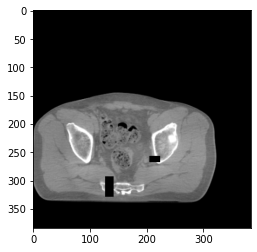

In [29]:
plt.imshow(x.squeeze(), 'gray'),

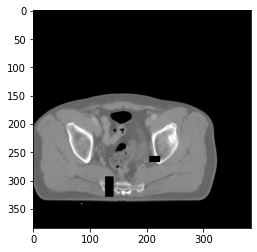

In [30]:
plt.imshow(y.squeeze(), 'gray')

In [31]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [32]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [33]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)

replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)

In [34]:
tf_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(tf_discriminator)
replace_bn_to_instanceNorm(tf_discriminator)

In [35]:
edge_discriminator = Discriminator(in_channel=E_IN_CHANNELS, n_classes=E_N_CLASSES, activation=E_ACT)
replace_relu_to_leakyReLU(edge_discriminator)
replace_bn_to_instanceNorm(edge_discriminator)

In [36]:
edge_discriminator

Discriminator(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): LeakyReLU(negative_slope=0.01)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (relu): LeakyReLU(negative_slope=0.01)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): InstanceNor

In [37]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME, lr=GEN_init_lr)
tf_dis_optimizer = Optimizer(tf_discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)
edge_dis_optimizer = Optimizer(edge_discriminator.parameters(), name=E_OPTIM_NAME, lr=E_init_lr)

In [38]:
from codes.scheduler import Scheduler
tf_scheduler = Scheduler(tf_dis_optimizer, name=DIS_scheduler, T_0=10, T_mult=2)
edge_scheduler = Scheduler(edge_dis_optimizer, name=E_scheduler, T_0=10, T_mult=2)

In [39]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet34"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [40]:
wandb.watch(model)
wandb.watch(tf_discriminator)
wandb.watch(edge_discriminator)

max_score = 0

for epoch in range(EPOCH):
        
        loss_air, loss_bone, loss_edge_gen, loss_tf_gen, loss_edge_dis, loss_tf_dis, tf_lr, edge_lr = train_a2b_epoch(epoch, model, gen_optimizer, 
                                                                                             tf_discriminator, tf_dis_optimizer, tf_scheduler, 
                                                                                             edge_discriminator, edge_dis_optimizer, edge_scheduler,
                                                                                             trainloader, device)
        
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, \
            score_air_train, score_bone_train, score_cont_train, score_tf_acc_train, score_edge_acc_train = eval_epoch(model, tf_discriminator, edge_discriminator, trainloader, device)
        
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, \
            score_air_test, score_bone_test, score_cont_test, score_tf_acc_test, score_edge_acc_test = eval_epoch(model, tf_discriminator, edge_discriminator, testloader, device)

        wandb.log({
            "lr scheduler tf": tf_lr,
            "lr scheduler edge": edge_lr,
            
            "loss mask": loss_air,
            "loss bone": loss_bone,
            "loss gen": loss_tf_gen,
            "loss dis": loss_tf_dis,
            "loss edge gen": loss_edge_gen,
            "loss edge dis": loss_edge_dis,
            
            "trainset cont score": score_cont_train,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_tf_acc_train,
            "trainset edge acc score": score_edge_acc_train,
            
            "testset cont score": score_cont_test,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_tf_acc_test,
            "testset edge acc score": score_edge_acc_test
        })
        
        
        if score_air_test +  score_bone_test + score_cont_test >= max_score:
            max_score = score_air_test +  score_bone_test + score_cont_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "tf_discriminator": tf_discriminator.state_dict(),
                "tf_dis_optimizer": tf_dis_optimizer.state_dict(),
                "tf_scheduler": tf_scheduler.state_dict(),
                "edge_discriminator": edge_discriminator.state_dict(),
                "edge_dis_optimizer": edge_dis_optimizer.state_dict(),
                "edge_scheduler": edge_scheduler.state_dict()
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

168it [01:23,  2.02it/s]
168it [01:42,  1.64it/s]
168it [00:31,  5.34it/s]
24it [00:04,  5.05it/s]
168it [00:44,  3.81it/s]
168it [01:40,  1.67it/s]
168it [00:31,  5.38it/s]
24it [00:04,  5.07it/s]
168it [00:44,  3.80it/s]
168it [01:44,  1.61it/s]
168it [00:57,  2.91it/s]
24it [00:08,  2.73it/s]
168it [01:13,  2.29it/s]
168it [02:37,  1.07it/s]
168it [00:52,  3.20it/s]
24it [00:07,  3.28it/s]
168it [01:16,  2.20it/s]
168it [02:40,  1.05it/s]
168it [00:52,  3.19it/s]
24it [00:07,  3.12it/s]
168it [01:11,  2.35it/s]
168it [02:39,  1.06it/s]
168it [00:52,  3.19it/s]
24it [00:07,  3.05it/s]
168it [01:13,  2.28it/s]
168it [02:31,  1.11it/s]
168it [00:55,  3.05it/s]
24it [00:07,  3.04it/s]
168it [01:13,  2.27it/s]
168it [02:31,  1.11it/s]
168it [00:55,  3.02it/s]
24it [00:08,  2.69it/s]
168it [01:15,  2.22it/s]
168it [02:39,  1.05it/s]
168it [00:52,  3.22it/s]
24it [00:08,  2.91it/s]
168it [01:09,  2.42it/s]
168it [02:39,  1.05it/s]
168it [00:52,  3.22it/s]
24it [00:07,  3.07it/s]
168it [01:

In [41]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [42]:
model = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)
replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [43]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.8616461157798767
psnr score = 24.406099319458008
snr score = 14.469038009643555
mae error = 0.021347757428884506
air dice score = 0.9963247577681292
bone dice score = 0.8291785176538534
contour dice score = 0.5077472925186157


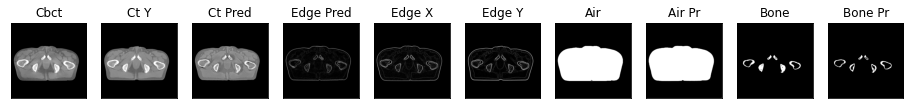

1it [00:00,  1.48it/s]

ssim score = 0.8595778346061707
psnr score = 23.959815979003906
snr score = 14.070287704467773
mae error = 0.022387024015188217
air dice score = 0.9961123873475918
bone dice score = 0.8441579904173829
contour dice score = 0.5388291478157043


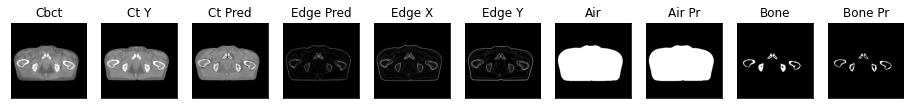

2it [00:01,  1.62it/s]

ssim score = 0.8559170961380005
psnr score = 23.601470947265625
snr score = 13.874839782714844
mae error = 0.023891933262348175
air dice score = 0.9959572964910943
bone dice score = 0.8399283055309537
contour dice score = 0.5873205661773682


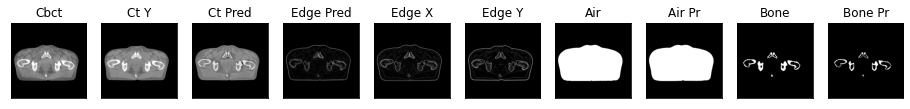

3it [00:01,  1.72it/s]

ssim score = 0.8520210385322571
psnr score = 23.371692657470703
snr score = 13.73431396484375
mae error = 0.02472524717450142
air dice score = 0.9961070368258625
bone dice score = 0.8089859119201804
contour dice score = 0.620730996131897


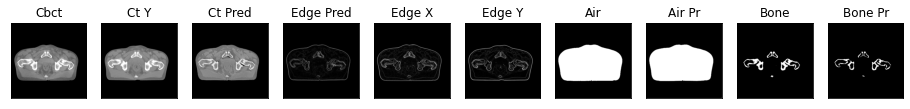

4it [00:02,  1.86it/s]

ssim score = 0.8511912822723389
psnr score = 23.294580459594727
snr score = 13.697504043579102
mae error = 0.025363121181726456
air dice score = 0.9959966079634015
bone dice score = 0.777595500354141
contour dice score = 0.6422569155693054


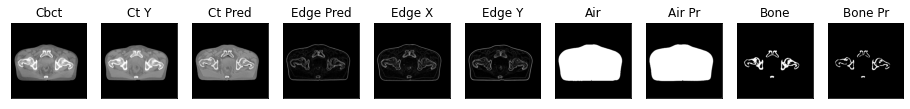

5it [00:02,  1.93it/s]

ssim score = 0.848964273929596
psnr score = 23.152572631835938
snr score = 13.692030906677246
mae error = 0.026841629296541214
air dice score = 0.9957610331986414
bone dice score = 0.7228790707350873
contour dice score = 0.6694762110710144


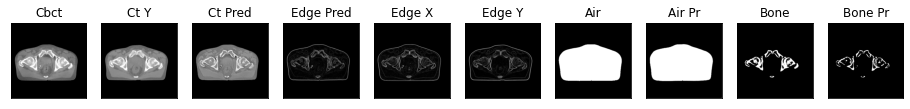

6it [00:03,  2.00it/s]

ssim score = 0.8463320732116699
psnr score = 22.951507568359375
snr score = 13.466911315917969
mae error = 0.02712862379848957
air dice score = 0.995752995832756
bone dice score = 0.692080318013535
contour dice score = 0.6243961453437805


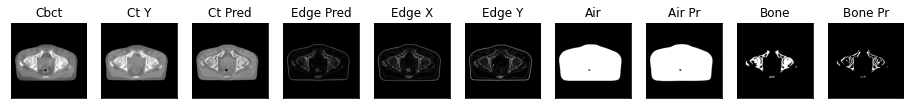

7it [00:03,  2.02it/s]

ssim score = 0.847930908203125
psnr score = 23.457931518554688
snr score = 13.787796020507812
mae error = 0.025102907791733742
air dice score = 0.9953491169336294
bone dice score = 0.7236856607547262
contour dice score = 0.5684848427772522


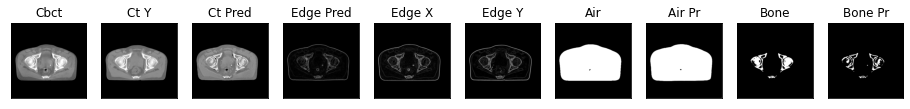

8it [00:04,  2.03it/s]

ssim score = 0.8508803844451904
psnr score = 23.812442779541016
snr score = 14.047752380371094
mae error = 0.023671969771385193
air dice score = 0.9956250000000044
bone dice score = 0.7407933688603813
contour dice score = 0.5492101907730103


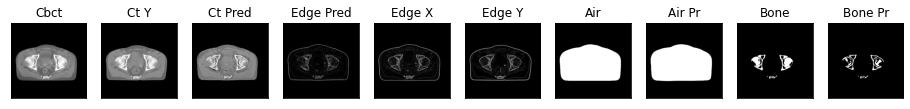

9it [00:04,  2.05it/s]

ssim score = 0.8508331179618835
psnr score = 23.62590789794922
snr score = 13.845935821533203
mae error = 0.023739218711853027
air dice score = 0.9952279419230428
bone dice score = 0.7429416841358286
contour dice score = 0.486288845539093


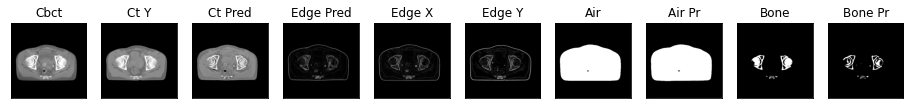

10it [00:05,  1.73it/s]

ssim score = 0.8575089573860168
psnr score = 23.941680908203125
snr score = 14.193978309631348
mae error = 0.022518066689372063
air dice score = 0.9949560955687207
bone dice score = 0.8040591330518159
contour dice score = 0.45243901014328003


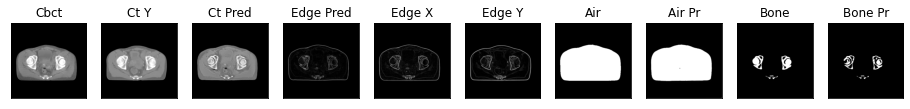

11it [00:05,  1.85it/s]

ssim score = 0.8572549223899841
psnr score = 23.47038459777832
snr score = 13.746393203735352
mae error = 0.023114586248993874
air dice score = 0.9948802642444314
bone dice score = 0.8090420881752336
contour dice score = 0.45110023021698


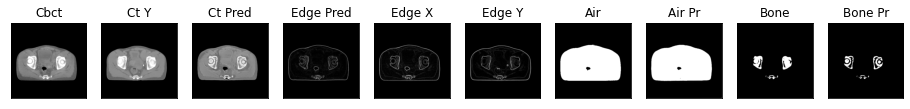

12it [00:06,  1.97it/s]

ssim score = 0.8587353229522705
psnr score = 23.238880157470703
snr score = 13.482965469360352
mae error = 0.023393532261252403
air dice score = 0.9945194325263907
bone dice score = 0.8690687642746883
contour dice score = 0.4244648218154907


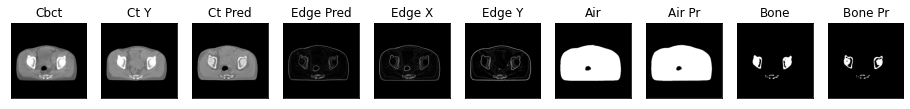

13it [00:06,  2.05it/s]

ssim score = 0.8596179485321045
psnr score = 23.221654891967773
snr score = 13.323783874511719
mae error = 0.022914990782737732
air dice score = 0.994341948603405
bone dice score = 0.7893045002953053
contour dice score = 0.4510166347026825


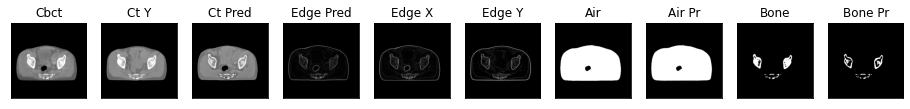

14it [00:07,  2.08it/s]

ssim score = 0.8558216094970703
psnr score = 23.039173126220703
snr score = 13.055639266967773
mae error = 0.023247770965099335
air dice score = 0.9949921123122095
bone dice score = 0.8100423472503019
contour dice score = 0.5098522305488586


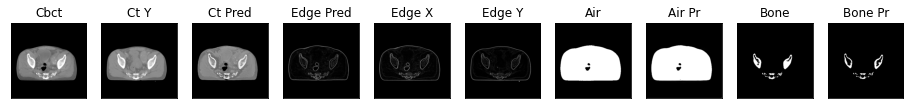

15it [00:07,  2.09it/s]

ssim score = 0.8489707708358765
psnr score = 22.691017150878906
snr score = 12.730965614318848
mae error = 0.024921486154198647
air dice score = 0.9954309692948404
bone dice score = 0.8384068278828107
contour dice score = 0.6037499904632568


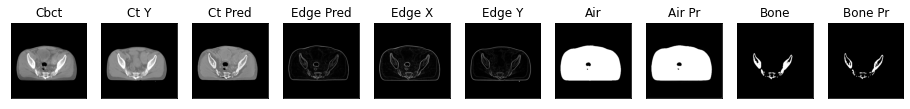

16it [00:07,  2.12it/s]

ssim score = 0.84650057554245
psnr score = 21.991308212280273
snr score = 12.02871322631836
mae error = 0.026871375739574432
air dice score = 0.9955636911812258
bone dice score = 0.8215552523898833
contour dice score = 0.5599497556686401


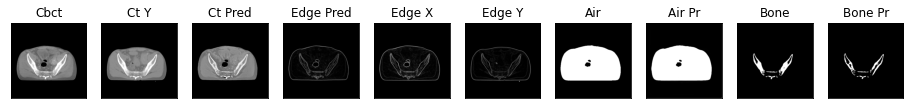

17it [00:08,  2.14it/s]

ssim score = 0.8423520922660828
psnr score = 21.49081802368164
snr score = 11.426464080810547
mae error = 0.028026359155774117
air dice score = 0.9943836123386438
bone dice score = 0.7673352435563419
contour dice score = 0.5148515105247498


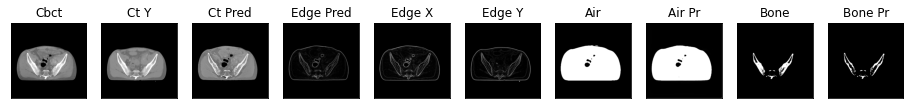

18it [00:08,  2.10it/s]

ssim score = 0.8362809419631958
psnr score = 21.129638671875
snr score = 11.014604568481445
mae error = 0.029627693817019463
air dice score = 0.993576392695072
bone dice score = 0.7778556412084393
contour dice score = 0.5006369352340698


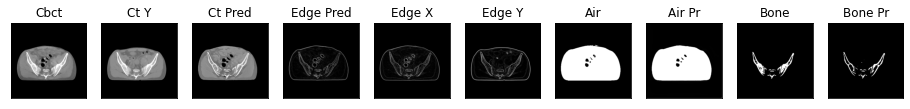

19it [00:09,  1.81it/s]

ssim score = 0.8422883152961731
psnr score = 21.123271942138672
snr score = 10.995926856994629
mae error = 0.02986397035419941
air dice score = 0.9937448287274602
bone dice score = 0.807817589579269
contour dice score = 0.4374209940433502


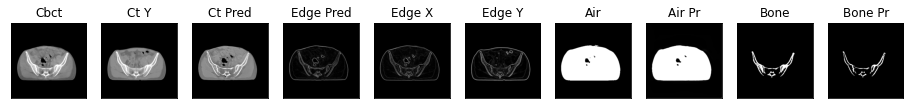

20it [00:10,  1.93it/s]

ssim score = 0.8408054113388062
psnr score = 21.086389541625977
snr score = 10.894197463989258
mae error = 0.029522793367505074
air dice score = 0.9933730578604518
bone dice score = 0.8205205811165175
contour dice score = 0.36980167031288147


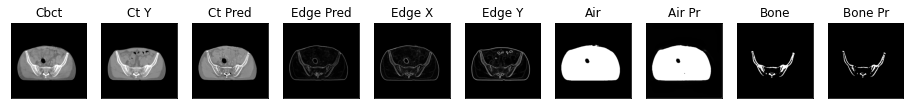

21it [00:10,  2.01it/s]

ssim score = 0.8412978053092957
psnr score = 21.162128448486328
snr score = 10.910507202148438
mae error = 0.02907615527510643
air dice score = 0.9925522130246623
bone dice score = 0.8226381461701925
contour dice score = 0.38426822423934937


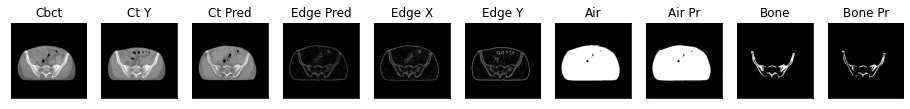

22it [00:11,  2.06it/s]

ssim score = 0.8463616967201233
psnr score = 21.233245849609375
snr score = 10.948196411132812
mae error = 0.028661975637078285
air dice score = 0.9928547972506337
bone dice score = 0.8249824561428073
contour dice score = 0.4737864136695862


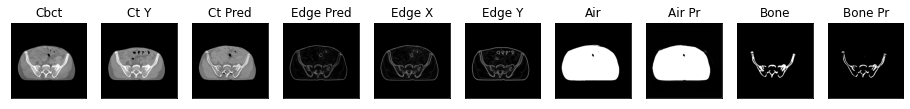

23it [00:11,  2.06it/s]

ssim score = 0.8461137413978577
psnr score = 21.20931625366211
snr score = 10.875702857971191
mae error = 0.02877492643892765
air dice score = 0.9923072526718955
bone dice score = 0.8214819850466147
contour dice score = 0.4168865382671356


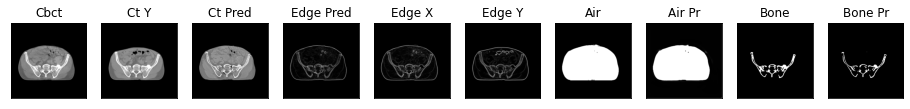

24it [00:11,  2.11it/s]

ssim score = 0.8415750861167908
psnr score = 20.96135139465332
snr score = 10.530738830566406
mae error = 0.029478861019015312
air dice score = 0.9913485178828323
bone dice score = 0.8080433919856059
contour dice score = 0.3413654565811157


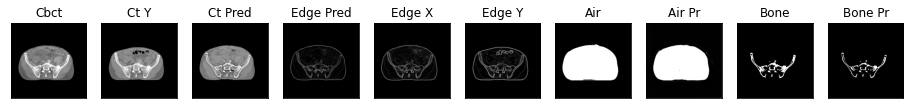

25it [00:12,  2.17it/s]

ssim score = 0.8468055725097656
psnr score = 21.0787353515625
snr score = 10.565386772155762
mae error = 0.029214471578598022
air dice score = 0.9912559241706265
bone dice score = 0.7975282671601692
contour dice score = 0.353658527135849


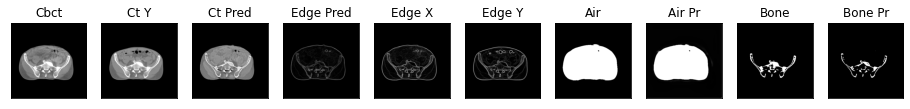

26it [00:12,  2.11it/s]

ssim score = 0.8452896475791931
psnr score = 21.20696258544922
snr score = 10.60242748260498
mae error = 0.028988786041736603
air dice score = 0.9909201919938208
bone dice score = 0.7931034482785442
contour dice score = 0.41828253865242004


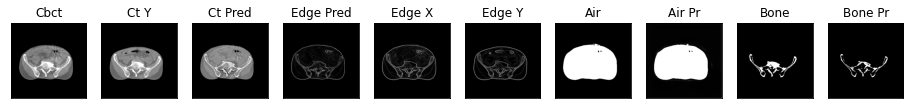

27it [00:13,  2.14it/s]

ssim score = 0.8449307084083557
psnr score = 21.049232482910156
snr score = 10.403594017028809
mae error = 0.029224302619695663
air dice score = 0.9894001593039772
bone dice score = 0.811878787881068
contour dice score = 0.4194229543209076


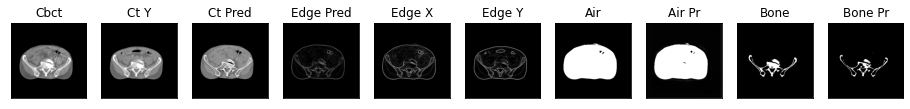

28it [00:13,  2.10it/s]

ssim score = 0.7991794943809509
psnr score = 22.65204429626465
snr score = 14.024202346801758
mae error = 0.031260956078767776
air dice score = 0.996085426886678
bone dice score = 0.9667634720888427
contour dice score = 0.39727774262428284


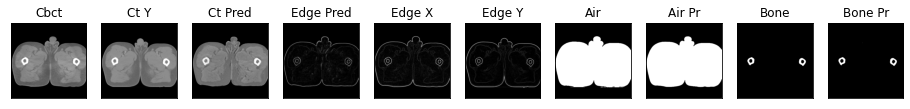

29it [00:14,  1.77it/s]

ssim score = 0.8061534762382507
psnr score = 22.848522186279297
snr score = 14.259939193725586
mae error = 0.031246768310666084
air dice score = 0.9956097860077285
bone dice score = 0.9565217391317568
contour dice score = 0.38038885593414307


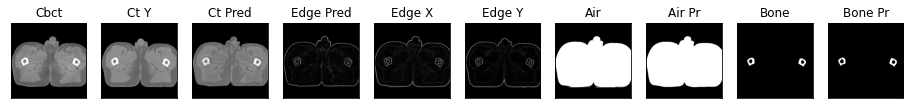

30it [00:15,  1.85it/s]

ssim score = 0.8066120147705078
psnr score = 22.97998046875
snr score = 14.478841781616211
mae error = 0.03217124938964844
air dice score = 0.9959759653726061
bone dice score = 0.9394459426344828
contour dice score = 0.39093735814094543


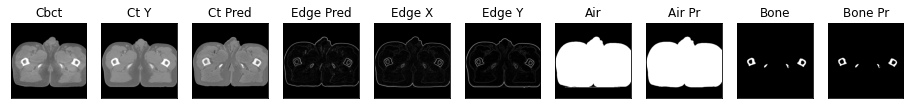

31it [00:15,  1.90it/s]

ssim score = 0.8124439120292664
psnr score = 22.869455337524414
snr score = 14.530877113342285
mae error = 0.03383617848157883
air dice score = 0.9973504645760759
bone dice score = 0.8701691896728376
contour dice score = 0.43922650814056396


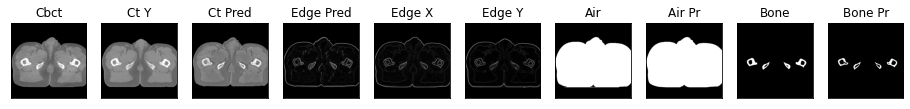

32it [00:16,  1.99it/s]

ssim score = 0.8116270899772644
psnr score = 22.727760314941406
snr score = 14.517324447631836
mae error = 0.03511752560734749
air dice score = 0.9974283460109266
bone dice score = 0.8493494278123632
contour dice score = 0.4102325439453125


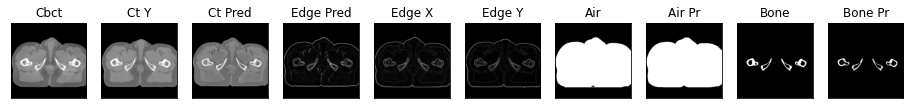

33it [00:16,  2.05it/s]

ssim score = 0.816834568977356
psnr score = 22.778427124023438
snr score = 14.67123031616211
mae error = 0.03585224598646164
air dice score = 0.9978647345313225
bone dice score = 0.811544991513702
contour dice score = 0.4314272403717041


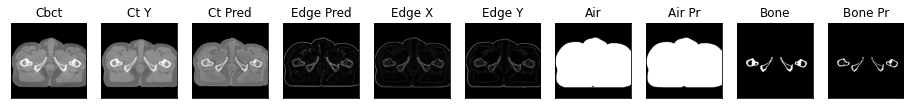

34it [00:16,  2.11it/s]

ssim score = 0.814797043800354
psnr score = 22.728240966796875
snr score = 14.68814468383789
mae error = 0.036868780851364136
air dice score = 0.9978490254890492
bone dice score = 0.7870419543310271
contour dice score = 0.4037209451198578


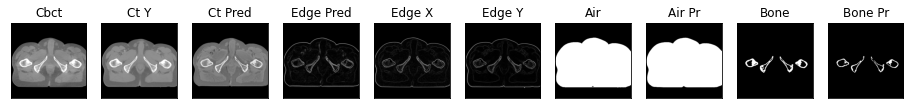

35it [00:17,  2.15it/s]

ssim score = 0.8107948899269104
psnr score = 22.71505355834961
snr score = 14.665067672729492
mae error = 0.037253785878419876
air dice score = 0.9979745749585991
bone dice score = 0.7736782046434173
contour dice score = 0.4519721567630768


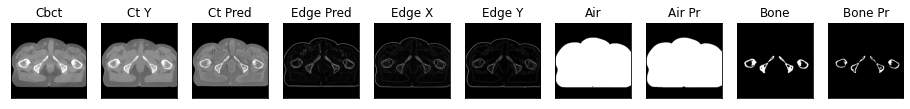

36it [00:17,  2.13it/s]

ssim score = 0.8146570920944214
psnr score = 22.88903045654297
snr score = 14.82537841796875
mae error = 0.03631521388888359
air dice score = 0.9980205317814631
bone dice score = 0.7901203922081405
contour dice score = 0.46296295523643494


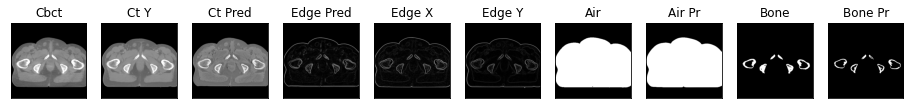

37it [00:18,  2.15it/s]

ssim score = 0.8189820647239685
psnr score = 23.05191421508789
snr score = 15.000266075134277
mae error = 0.0359639935195446
air dice score = 0.9981535904057957
bone dice score = 0.7966057441279817
contour dice score = 0.4960520267486572


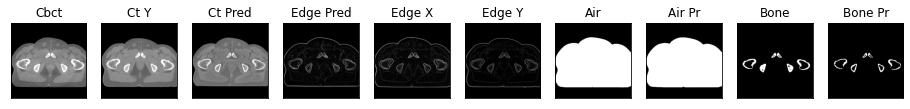

38it [00:18,  2.11it/s]

ssim score = 0.8224716782569885
psnr score = 23.010696411132812
snr score = 14.99813175201416
mae error = 0.036102890968322754
air dice score = 0.9979940890909319
bone dice score = 0.812574296660777
contour dice score = 0.48719143867492676


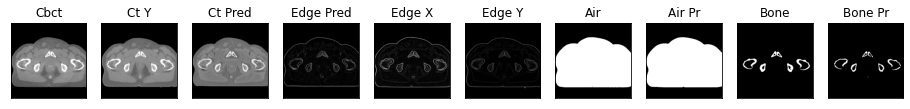

39it [00:19,  1.80it/s]

ssim score = 0.8122679591178894
psnr score = 22.491893768310547
snr score = 14.62061882019043
mae error = 0.03913704678416252
air dice score = 0.9980712967413828
bone dice score = 0.7983576642358763
contour dice score = 0.5060691237449646


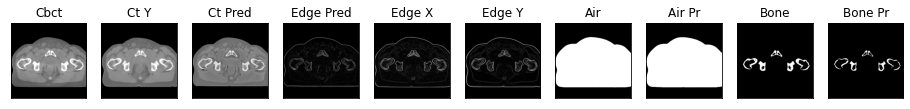

40it [00:20,  1.85it/s]

ssim score = 0.8115807175636292
psnr score = 22.19580841064453
snr score = 14.419218063354492
mae error = 0.04166743531823158
air dice score = 0.9981932723166539
bone dice score = 0.7321393034852522
contour dice score = 0.49180328845977783


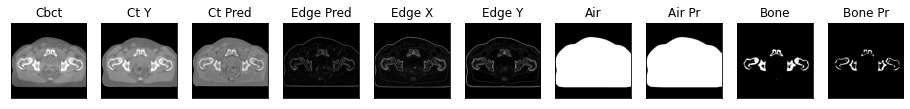

41it [00:20,  1.89it/s]

ssim score = 0.8017876148223877
psnr score = 21.730159759521484
snr score = 13.919525146484375
mae error = 0.043254584074020386
air dice score = 0.9977331297127053
bone dice score = 0.6866267465101135
contour dice score = 0.4253521263599396


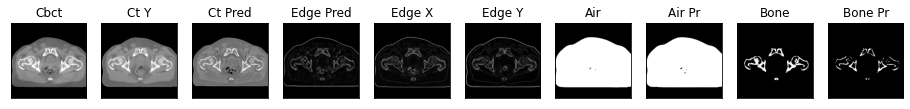

42it [00:21,  1.94it/s]

ssim score = 0.7978654503822327
psnr score = 21.09939956665039
snr score = 13.360949516296387
mae error = 0.04602893069386482
air dice score = 0.9972505702965558
bone dice score = 0.6052655225123077
contour dice score = 0.4111006557941437


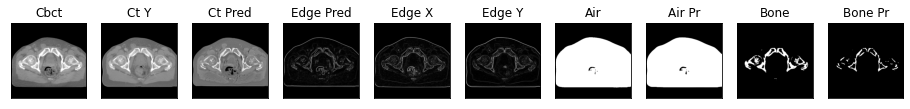

43it [00:21,  2.00it/s]

ssim score = 0.8016107082366943
psnr score = 21.648645401000977
snr score = 13.774100303649902
mae error = 0.04236971586942673
air dice score = 0.998091430704486
bone dice score = 0.6883344276681075
contour dice score = 0.4804152846336365


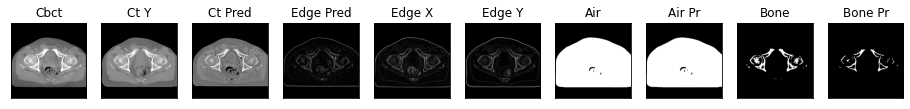

44it [00:22,  1.99it/s]

ssim score = 0.8118877410888672
psnr score = 22.394636154174805
snr score = 14.341527938842773
mae error = 0.0383436419069767
air dice score = 0.9980559546952932
bone dice score = 0.690766015004417
contour dice score = 0.5846735835075378


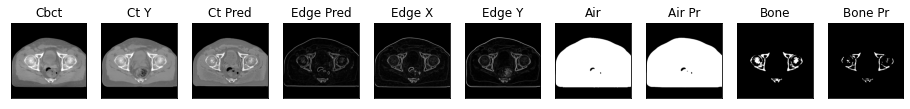

45it [00:22,  2.01it/s]

ssim score = 0.8063057065010071
psnr score = 22.60140609741211
snr score = 14.457711219787598
mae error = 0.037571001797914505
air dice score = 0.9982169085425202
bone dice score = 0.7103136556675754
contour dice score = 0.5880114436149597


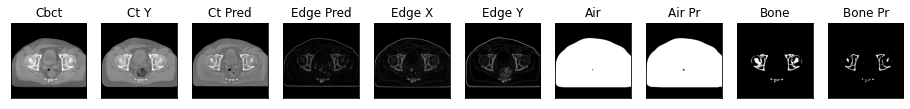

46it [00:22,  2.08it/s]

ssim score = 0.8075531125068665
psnr score = 22.496536254882812
snr score = 14.3685302734375
mae error = 0.03795852139592171
air dice score = 0.9985672830587301
bone dice score = 0.6984413242342079
contour dice score = 0.6066666841506958


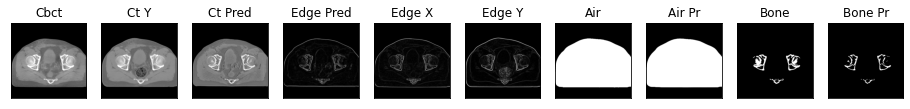

47it [00:23,  2.13it/s]

ssim score = 0.7949841022491455
psnr score = 22.260522842407227
snr score = 14.142555236816406
mae error = 0.03869802504777908
air dice score = 0.9985537051389245
bone dice score = 0.6807755970716389
contour dice score = 0.5982824563980103


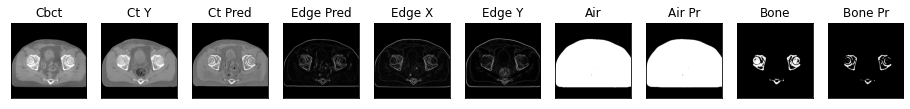

48it [00:23,  2.14it/s]

ssim score = 0.8060423731803894
psnr score = 22.246002197265625
snr score = 14.18962574005127
mae error = 0.0386076383292675
air dice score = 0.9984384855146577
bone dice score = 0.744124752912979
contour dice score = 0.5935114622116089


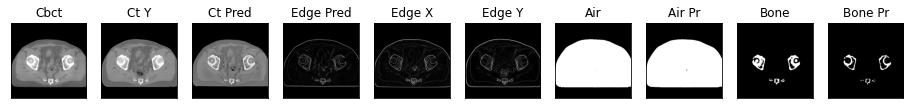

49it [00:24,  1.75it/s]

ssim score = 0.8049213886260986
psnr score = 22.258193969726562
snr score = 14.271897315979004
mae error = 0.03934948518872261
air dice score = 0.9983124796730516
bone dice score = 0.790880829017711
contour dice score = 0.5869461894035339


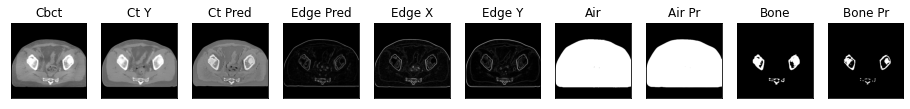

50it [00:25,  1.81it/s]

ssim score = 0.8192976117134094
psnr score = 22.72287368774414
snr score = 14.617470741271973
mae error = 0.03716655820608139
air dice score = 0.9982631536955558
bone dice score = 0.7614237049246866
contour dice score = 0.5761904716491699


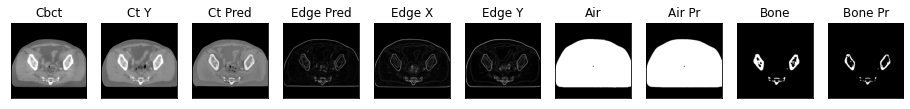

51it [00:25,  1.89it/s]

ssim score = 0.8092166185379028
psnr score = 21.943586349487305
snr score = 13.91981029510498
mae error = 0.04041710123419762
air dice score = 0.9979515988568217
bone dice score = 0.7368970557555137
contour dice score = 0.5505026578903198


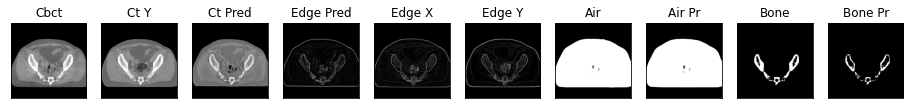

52it [00:26,  1.97it/s]

ssim score = 0.8134617805480957
psnr score = 21.77095603942871
snr score = 13.8273286819458
mae error = 0.04218792915344238
air dice score = 0.997250880146948
bone dice score = 0.6798649758262943
contour dice score = 0.49447911977767944


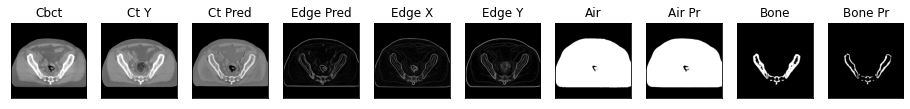

53it [00:26,  1.98it/s]

ssim score = 0.7929245829582214
psnr score = 21.51446533203125
snr score = 13.592394828796387
mae error = 0.04325993359088898
air dice score = 0.9974407681360379
bone dice score = 0.6713338246161447
contour dice score = 0.45708775520324707


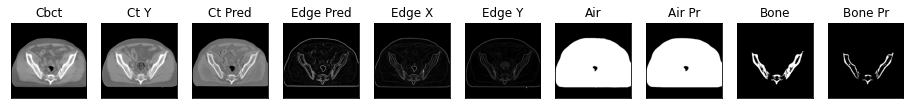

54it [00:27,  2.04it/s]

ssim score = 0.7941552400588989
psnr score = 21.779438018798828
snr score = 13.869905471801758
mae error = 0.042720481753349304
air dice score = 0.9974132343052399
bone dice score = 0.6815144766176547
contour dice score = 0.43056222796440125


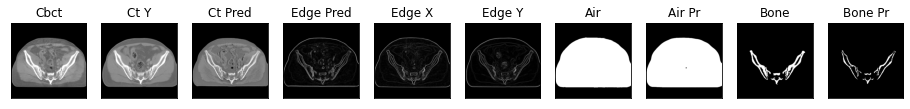

55it [00:27,  2.06it/s]

ssim score = 0.7824887633323669
psnr score = 20.77944564819336
snr score = 10.65965461730957
mae error = 0.032350435853004456
air dice score = 0.9959234646090754
bone dice score = 0.9129078014209104
contour dice score = 0.5649530291557312


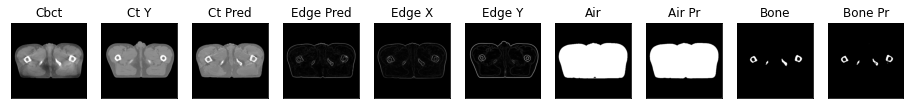

56it [00:27,  2.12it/s]

ssim score = 0.7776397466659546
psnr score = 20.36368179321289
snr score = 10.456869125366211
mae error = 0.03437137231230736
air dice score = 0.9964991890526571
bone dice score = 0.857943925236964
contour dice score = 0.5500550270080566


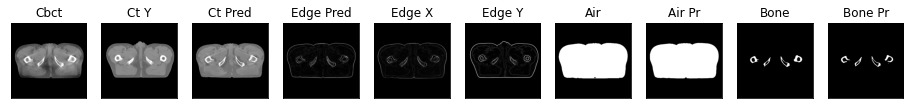

57it [00:28,  2.15it/s]

ssim score = 0.775383710861206
psnr score = 20.23546600341797
snr score = 10.459794998168945
mae error = 0.03545534610748291
air dice score = 0.996465621336721
bone dice score = 0.8394898856675573
contour dice score = 0.5841096043586731


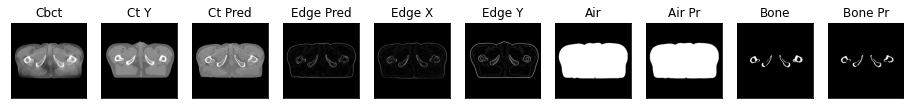

58it [00:28,  2.14it/s]

ssim score = 0.7745079398155212
psnr score = 20.367366790771484
snr score = 10.66209602355957
mae error = 0.035463787615299225
air dice score = 0.9962540245111403
bone dice score = 0.8352309344825943
contour dice score = 0.5703338980674744


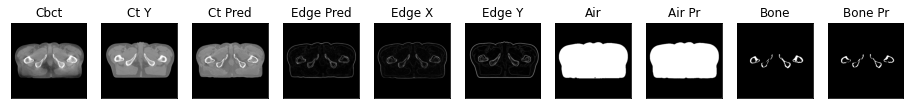

59it [00:29,  1.86it/s]

ssim score = 0.7683135271072388
psnr score = 20.307025909423828
snr score = 10.649323463439941
mae error = 0.036180898547172546
air dice score = 0.9955937893411705
bone dice score = 0.8225053078593948
contour dice score = 0.5345672369003296


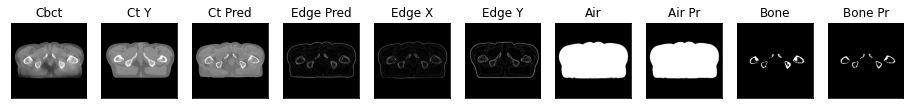

60it [00:29,  2.02it/s]

ssim score = 0.764213502407074
psnr score = 20.334205627441406
snr score = 10.682117462158203
mae error = 0.03612499684095383
air dice score = 0.9952954295969793
bone dice score = 0.832436905257914
contour dice score = 0.5679405331611633


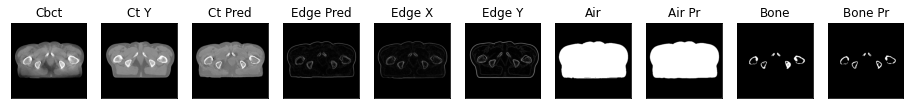

61it [00:30,  2.14it/s]

ssim score = 0.7655948996543884
psnr score = 20.331783294677734
snr score = 10.67319393157959
mae error = 0.036307018250226974
air dice score = 0.9946684727866394
bone dice score = 0.8609107768419346
contour dice score = 0.5762892365455627


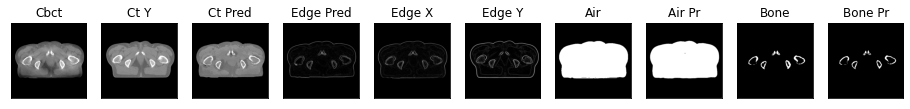

62it [00:30,  2.20it/s]

ssim score = 0.7657042145729065
psnr score = 20.299877166748047
snr score = 10.65539836883545
mae error = 0.03624023124575615
air dice score = 0.9950314214981952
bone dice score = 0.877234803339745
contour dice score = 0.5458399653434753


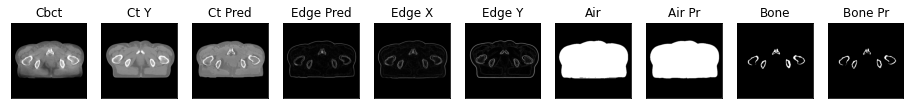

63it [00:31,  2.25it/s]

ssim score = 0.7679374814033508
psnr score = 20.31287956237793
snr score = 10.72640609741211
mae error = 0.036204129457473755
air dice score = 0.9948977826974342
bone dice score = 0.8693620844587716
contour dice score = 0.5866666436195374


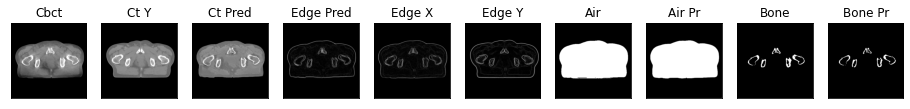

64it [00:31,  2.32it/s]

ssim score = 0.7592324614524841
psnr score = 20.090164184570312
snr score = 10.602250099182129
mae error = 0.03775628283619881
air dice score = 0.9948852413769353
bone dice score = 0.8465195246206024
contour dice score = 0.567211389541626


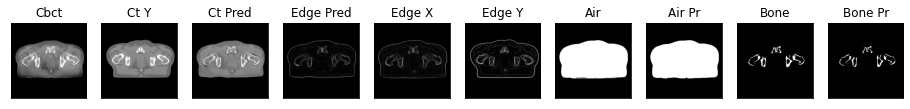

65it [00:32,  2.23it/s]

ssim score = 0.751483142375946
psnr score = 19.97960662841797
snr score = 10.527520179748535
mae error = 0.038887444883584976
air dice score = 0.9951087611732127
bone dice score = 0.8375816993490591
contour dice score = 0.475321888923645


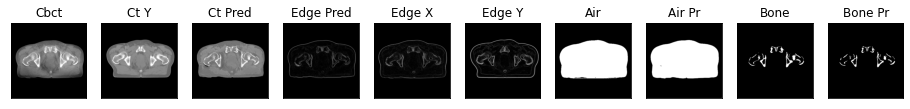

66it [00:32,  2.22it/s]

ssim score = 0.7432446479797363
psnr score = 19.900707244873047
snr score = 10.481328964233398
mae error = 0.03946767374873161
air dice score = 0.9954659256136525
bone dice score = 0.7875742348136504
contour dice score = 0.5326203107833862


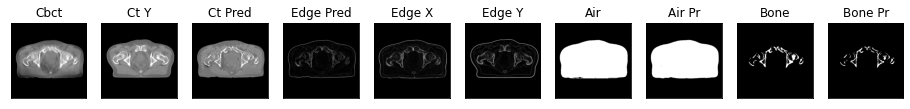

67it [00:33,  2.23it/s]

ssim score = 0.7417470812797546
psnr score = 19.916717529296875
snr score = 10.614157676696777
mae error = 0.03993416577577591
air dice score = 0.9955893353050963
bone dice score = 0.7575945443310974
contour dice score = 0.5922023057937622


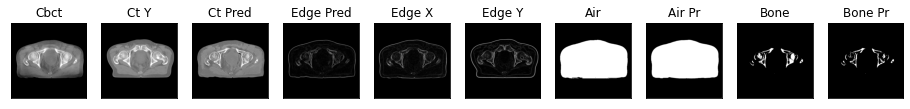

68it [00:33,  2.26it/s]

ssim score = 0.7444871068000793
psnr score = 20.031747817993164
snr score = 10.713199615478516
mae error = 0.03940309211611748
air dice score = 0.9959170341335981
bone dice score = 0.7683364677762295
contour dice score = 0.608364999294281


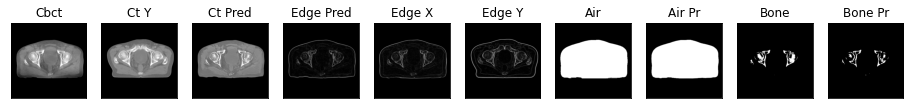

69it [00:34,  1.90it/s]

ssim score = 0.7600334882736206
psnr score = 20.6375675201416
snr score = 11.119856834411621
mae error = 0.03532875329256058
air dice score = 0.9959895229507527
bone dice score = 0.7891402714970291
contour dice score = 0.6212446093559265


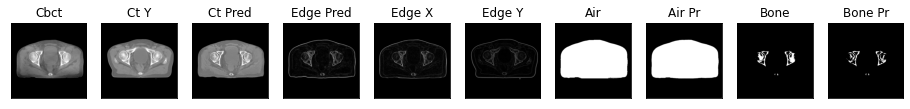

70it [00:34,  1.99it/s]

ssim score = 0.7746302485466003
psnr score = 21.360702514648438
snr score = 11.672597885131836
mae error = 0.03190024942159653
air dice score = 0.9956526585664958
bone dice score = 0.7889659840956343
contour dice score = 0.6075268983840942


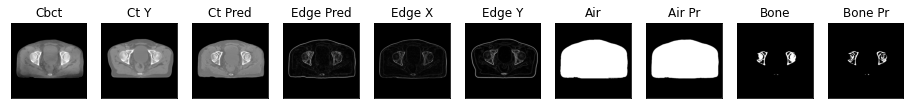

71it [00:35,  1.99it/s]

ssim score = 0.7796937823295593
psnr score = 21.685890197753906
snr score = 12.011956214904785
mae error = 0.03097371570765972
air dice score = 0.9956358035255899
bone dice score = 0.7797799394071157
contour dice score = 0.6179295778274536


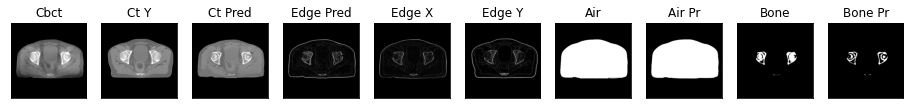

72it [00:35,  2.03it/s]

ssim score = 0.7845785021781921
psnr score = 21.761205673217773
snr score = 12.169098854064941
mae error = 0.0307441595941782
air dice score = 0.9964134444596286
bone dice score = 0.8098835379318557
contour dice score = 0.6193058490753174


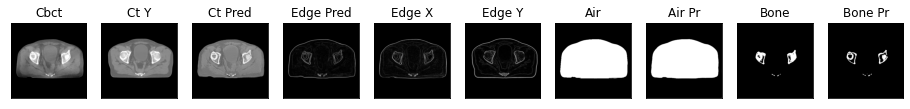

73it [00:36,  2.07it/s]

ssim score = 0.7817765474319458
psnr score = 21.509159088134766
snr score = 12.009224891662598
mae error = 0.03167383372783661
air dice score = 0.9966363798932185
bone dice score = 0.7882247992901298
contour dice score = 0.6534653306007385


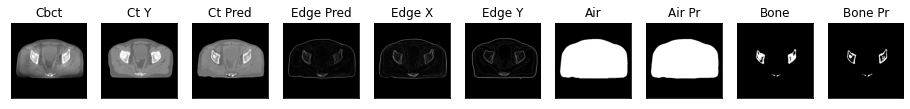

74it [00:36,  2.17it/s]

ssim score = 0.7826027274131775
psnr score = 21.83367156982422
snr score = 12.27031135559082
mae error = 0.030387768521904945
air dice score = 0.9964100518548096
bone dice score = 0.8272571101388193
contour dice score = 0.6523835062980652


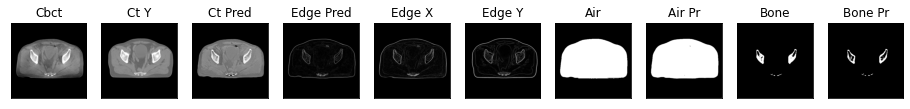

75it [00:36,  2.24it/s]

ssim score = 0.7857944369316101
psnr score = 22.094615936279297
snr score = 12.494860649108887
mae error = 0.029710931703448296
air dice score = 0.9957842413755115
bone dice score = 0.8288617886213646
contour dice score = 0.627263069152832


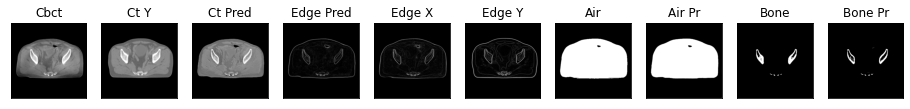

76it [00:37,  2.32it/s]

ssim score = 0.7855510115623474
psnr score = 21.837669372558594
snr score = 12.275657653808594
mae error = 0.0319058783352375
air dice score = 0.9956243003968694
bone dice score = 0.836416926179952
contour dice score = 0.6073132157325745


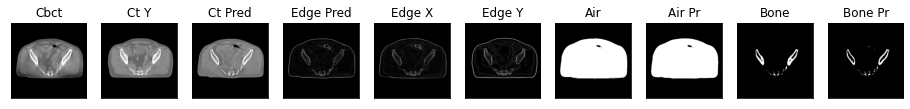

77it [00:37,  2.39it/s]

ssim score = 0.7861626744270325
psnr score = 21.582124710083008
snr score = 12.150619506835938
mae error = 0.0333576574921608
air dice score = 0.995179168576331
bone dice score = 0.8353856124459594
contour dice score = 0.6065136194229126


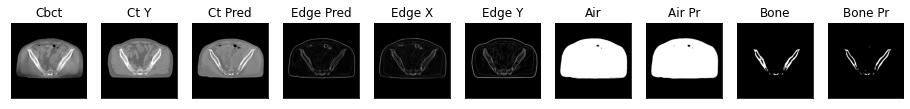

78it [00:38,  2.33it/s]

ssim score = 0.7902143001556396
psnr score = 21.590251922607422
snr score = 12.176495552062988
mae error = 0.033782798796892166
air dice score = 0.9950331831077152
bone dice score = 0.8301756803336173
contour dice score = 0.5964535474777222


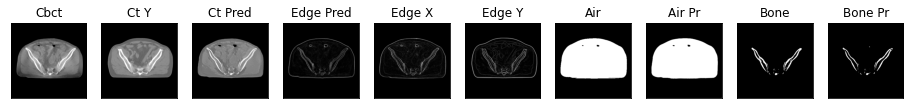

79it [00:39,  1.40it/s]

ssim score = 0.7935195565223694
psnr score = 21.98991584777832
snr score = 12.564889907836914
mae error = 0.032459210604429245
air dice score = 0.9950230887634727
bone dice score = 0.8542322652370026
contour dice score = 0.5735849142074585


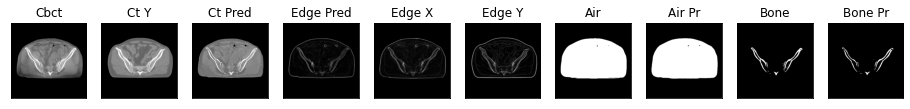

80it [00:39,  1.61it/s]

ssim score = 0.7942417860031128
psnr score = 21.978862762451172
snr score = 12.553098678588867
mae error = 0.03245224431157112
air dice score = 0.9944131201565404
bone dice score = 0.8338467113637643
contour dice score = 0.6071817278862


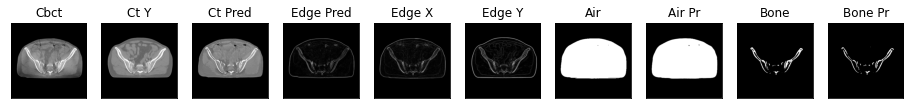

81it [00:40,  1.76it/s]

ssim score = 0.8324221968650818
psnr score = 23.732654571533203
snr score = 14.166790008544922
mae error = 0.023273728787899017
air dice score = 0.9957045289725172
bone dice score = 0.919045756749353
contour dice score = 0.4513038992881775


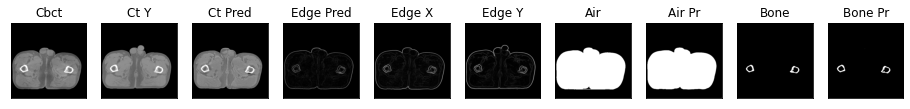

82it [00:40,  1.93it/s]

ssim score = 0.833939254283905
psnr score = 24.036216735839844
snr score = 14.53474235534668
mae error = 0.02272762358188629
air dice score = 0.9958672451467874
bone dice score = 0.8879911861958137
contour dice score = 0.3817034661769867


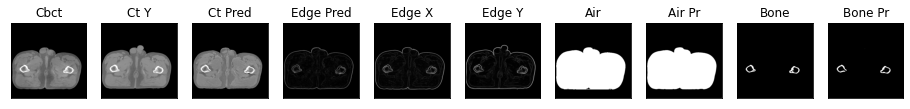

83it [00:41,  2.03it/s]

ssim score = 0.8410601615905762
psnr score = 25.249225616455078
snr score = 15.886964797973633
mae error = 0.022081464529037476
air dice score = 0.9961981350522591
bone dice score = 0.8881882124693624
contour dice score = 0.44354018568992615


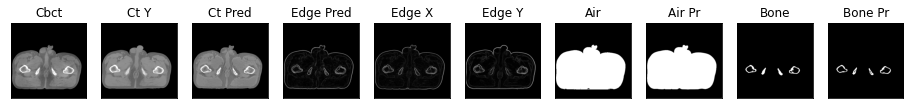

84it [00:41,  2.11it/s]

ssim score = 0.8412343859672546
psnr score = 24.93048858642578
snr score = 15.689718246459961
mae error = 0.023473432287573814
air dice score = 0.9968099343313336
bone dice score = 0.8870598994081605
contour dice score = 0.5164608955383301


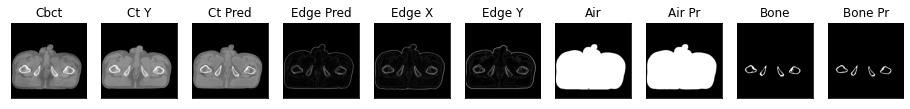

85it [00:41,  2.22it/s]

ssim score = 0.8392359018325806
psnr score = 24.661684036254883
snr score = 15.445087432861328
mae error = 0.024075621739029884
air dice score = 0.9973454624483861
bone dice score = 0.8826945412338515
contour dice score = 0.48962655663490295


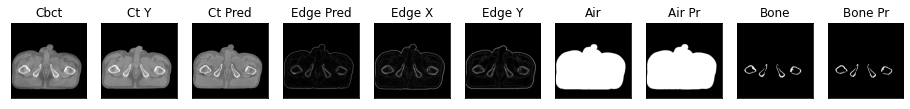

86it [00:42,  2.24it/s]

ssim score = 0.8392881155014038
psnr score = 24.62786102294922
snr score = 15.406867980957031
mae error = 0.02417713962495327
air dice score = 0.9971244545377059
bone dice score = 0.8676629846249152
contour dice score = 0.4921630024909973


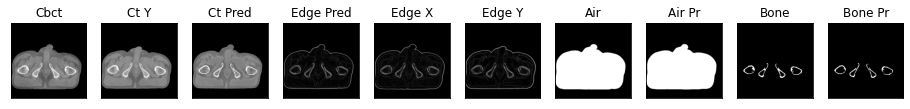

87it [00:42,  2.29it/s]

ssim score = 0.8387585878372192
psnr score = 24.254865646362305
snr score = 15.040124893188477
mae error = 0.025068415328860283
air dice score = 0.9969552585706009
bone dice score = 0.8730728616711072
contour dice score = 0.4686677157878876


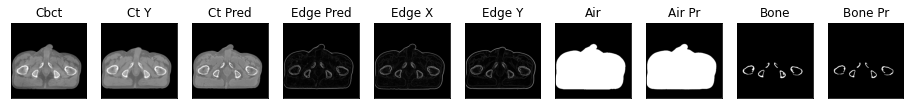

88it [00:43,  2.25it/s]

ssim score = 0.8377764821052551
psnr score = 24.12041664123535
snr score = 14.884123802185059
mae error = 0.025077402591705322
air dice score = 0.9970298795666594
bone dice score = 0.8890742285260826
contour dice score = 0.4710221290588379


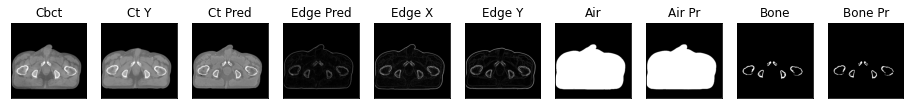

89it [00:44,  1.93it/s]

ssim score = 0.8396873474121094
psnr score = 24.05521583557129
snr score = 14.835830688476562
mae error = 0.025444474071264267
air dice score = 0.9969442262983175
bone dice score = 0.893709327550903
contour dice score = 0.472457617521286


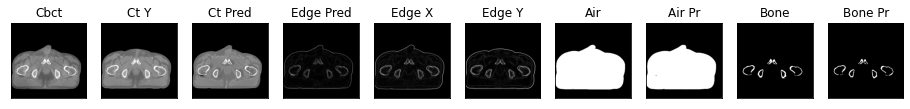

90it [00:44,  2.03it/s]

ssim score = 0.8398405909538269
psnr score = 24.13092041015625
snr score = 14.980130195617676
mae error = 0.02574237994849682
air dice score = 0.9971590022166049
bone dice score = 0.8773533174944735
contour dice score = 0.5368196368217468


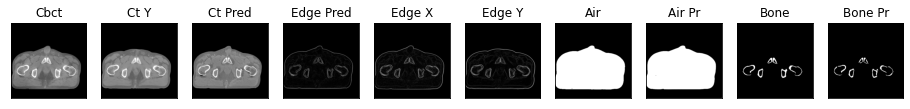

91it [00:44,  2.13it/s]

ssim score = 0.8379897475242615
psnr score = 24.0841007232666
snr score = 15.014667510986328
mae error = 0.025915225967764854
air dice score = 0.9972020847211903
bone dice score = 0.8597591995953916
contour dice score = 0.5571658611297607


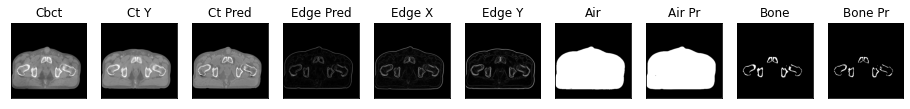

92it [00:45,  2.17it/s]

ssim score = 0.8348977565765381
psnr score = 24.085844039916992
snr score = 15.067113876342773
mae error = 0.026624655351042747
air dice score = 0.9977735644210891
bone dice score = 0.838519489029831
contour dice score = 0.6157979369163513


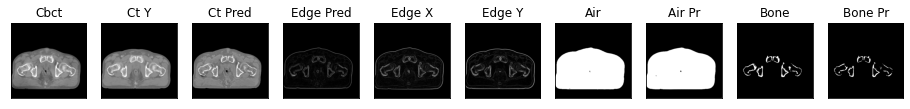

93it [00:45,  2.25it/s]

ssim score = 0.8341385722160339
psnr score = 23.901994705200195
snr score = 14.999533653259277
mae error = 0.027476198971271515
air dice score = 0.9980666798185062
bone dice score = 0.7898844833001891
contour dice score = 0.5634408593177795


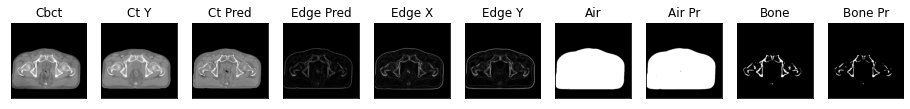

94it [00:46,  2.31it/s]

ssim score = 0.8338372111320496
psnr score = 23.861095428466797
snr score = 14.920400619506836
mae error = 0.026964949443936348
air dice score = 0.9979852462917442
bone dice score = 0.7888962765992538
contour dice score = 0.5169628262519836


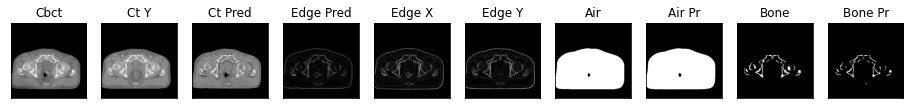

95it [00:46,  2.29it/s]

ssim score = 0.8266638517379761
psnr score = 23.231916427612305
snr score = 14.195549011230469
mae error = 0.027868211269378662
air dice score = 0.9974660069225194
bone dice score = 0.7766323024089873
contour dice score = 0.5288720726966858


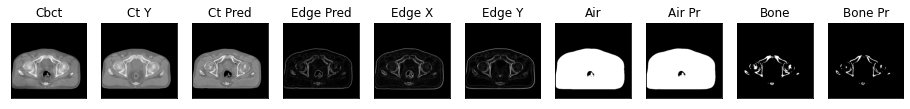

96it [00:46,  2.34it/s]

ssim score = 0.8309614062309265
psnr score = 23.35222053527832
snr score = 14.15609359741211
mae error = 0.026373643428087234
air dice score = 0.9974571497545687
bone dice score = 0.804318999814277
contour dice score = 0.4867495894432068


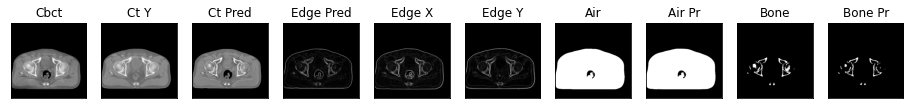

97it [00:47,  2.31it/s]

ssim score = 0.8295640349388123
psnr score = 23.183156967163086
snr score = 13.870607376098633
mae error = 0.026352614164352417
air dice score = 0.9971215299799994
bone dice score = 0.79582183681916
contour dice score = 0.4644601047039032


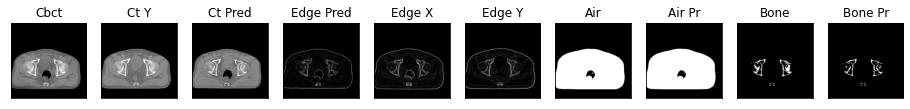

98it [00:47,  2.32it/s]

ssim score = 0.8284317851066589
psnr score = 23.064577102661133
snr score = 13.706932067871094
mae error = 0.026693375781178474
air dice score = 0.99766838742402
bone dice score = 0.7843063638110699
contour dice score = 0.4983677864074707


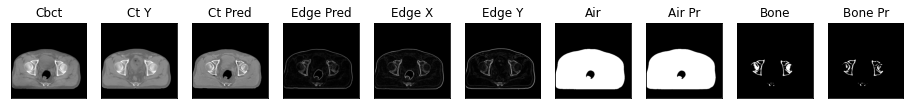

99it [00:48,  1.95it/s]

ssim score = 0.8242477178573608
psnr score = 22.544519424438477
snr score = 13.193549156188965
mae error = 0.028289709240198135
air dice score = 0.9973295761726131
bone dice score = 0.8317587209332893
contour dice score = 0.48689955472946167


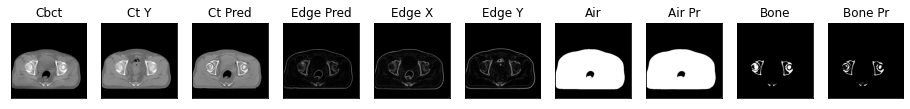

100it [00:48,  2.04it/s]

ssim score = 0.8297880291938782
psnr score = 22.38909149169922
snr score = 13.068225860595703
mae error = 0.02876490354537964
air dice score = 0.9973812748840476
bone dice score = 0.8508044030507907
contour dice score = 0.4896174967288971


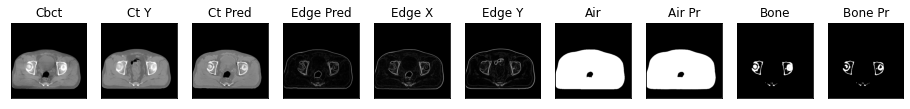

101it [00:49,  2.10it/s]

ssim score = 0.832969605922699
psnr score = 22.779817581176758
snr score = 13.416365623474121
mae error = 0.027447279542684555
air dice score = 0.9973590105311527
bone dice score = 0.8609715242906948
contour dice score = 0.5035577416419983


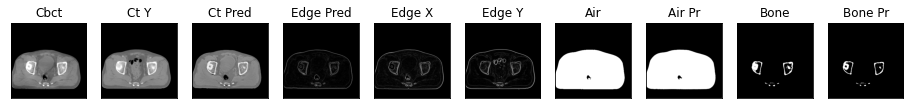

102it [00:49,  2.17it/s]

ssim score = 0.8327029347419739
psnr score = 22.926637649536133
snr score = 13.472977638244629
mae error = 0.026700135320425034
air dice score = 0.9970993473531569
bone dice score = 0.8653128885233048
contour dice score = 0.5032822489738464


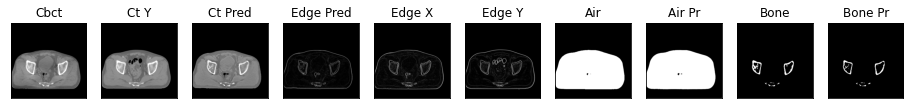

103it [00:50,  2.17it/s]

ssim score = 0.8336524367332458
psnr score = 22.676422119140625
snr score = 13.157038688659668
mae error = 0.027310850098729134
air dice score = 0.9967604120689252
bone dice score = 0.8898641588319778
contour dice score = 0.5290889143943787


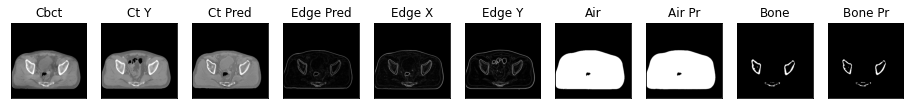

104it [00:50,  2.18it/s]

ssim score = 0.8315433859825134
psnr score = 22.613000869750977
snr score = 13.093314170837402
mae error = 0.027771323919296265
air dice score = 0.996452800442774
bone dice score = 0.8696629213507554
contour dice score = 0.5244640111923218


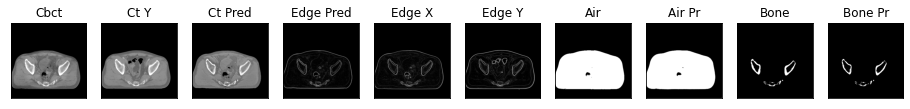

105it [00:51,  2.20it/s]

ssim score = 0.8238809704780579
psnr score = 22.320209503173828
snr score = 12.876687049865723
mae error = 0.02928893454372883
air dice score = 0.9964285109768306
bone dice score = 0.8221369161896651
contour dice score = 0.6081677675247192


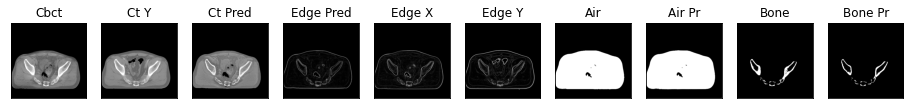

106it [00:51,  2.27it/s]

ssim score = 0.8309681415557861
psnr score = 22.42184066772461
snr score = 13.01390266418457
mae error = 0.02949494868516922
air dice score = 0.9967886196175333
bone dice score = 0.8065930742506185
contour dice score = 0.6574738025665283


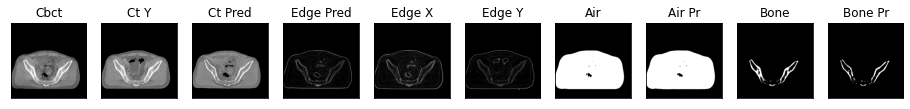

107it [00:52,  2.28it/s]

ssim score = 0.8305448889732361
psnr score = 22.818737030029297
snr score = 13.349099159240723
mae error = 0.028776397928595543
air dice score = 0.9965894873948169
bone dice score = 0.810207336526153
contour dice score = 0.619390606880188


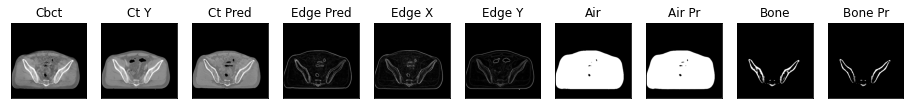

108it [00:52,  2.29it/s]

ssim score = 0.8255729079246521
psnr score = 22.831621170043945
snr score = 13.300724029541016
mae error = 0.028661608695983887
air dice score = 0.9963819737671542
bone dice score = 0.8224483098158443
contour dice score = 0.5624650120735168


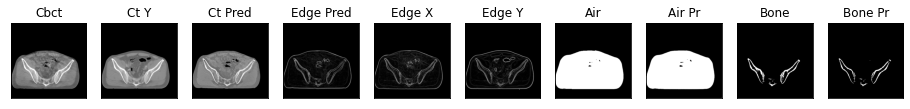

109it [00:53,  1.95it/s]

ssim score = 0.7458699941635132
psnr score = 21.7390079498291
snr score = 13.436312675476074
mae error = 0.037727221846580505
air dice score = 0.9970487489777311
bone dice score = 0.9562682215757606
contour dice score = 0.3982340097427368


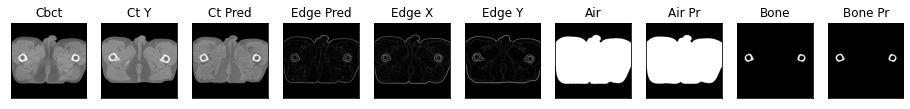

110it [00:53,  2.03it/s]

ssim score = 0.744488537311554
psnr score = 21.486661911010742
snr score = 13.28825855255127
mae error = 0.03918677195906639
air dice score = 0.9969474106027408
bone dice score = 0.9277860326915962
contour dice score = 0.42240995168685913


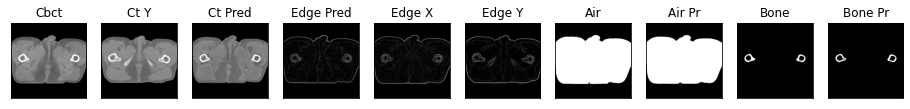

111it [00:54,  2.13it/s]

ssim score = 0.7431574463844299
psnr score = 21.068429946899414
snr score = 12.99798583984375
mae error = 0.042181916534900665
air dice score = 0.9969808040224637
bone dice score = 0.9098440545830935
contour dice score = 0.37796685099601746


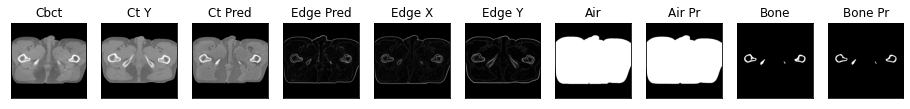

112it [00:54,  2.14it/s]

ssim score = 0.7423847913742065
psnr score = 20.807950973510742
snr score = 12.769794464111328
mae error = 0.04364622011780739
air dice score = 0.9969422542966617
bone dice score = 0.8694526627243074
contour dice score = 0.3441150188446045


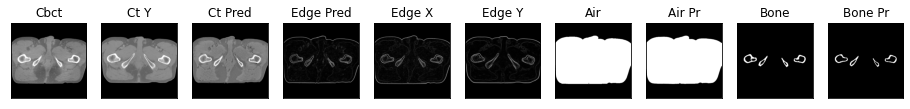

113it [00:54,  2.16it/s]

ssim score = 0.7303068041801453
psnr score = 20.602645874023438
snr score = 12.594727516174316
mae error = 0.04507884010672569
air dice score = 0.9967747212938528
bone dice score = 0.8562724014362675
contour dice score = 0.34130924940109253


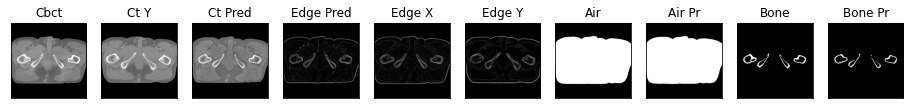

114it [00:55,  2.25it/s]

ssim score = 0.7274937033653259
psnr score = 20.490549087524414
snr score = 12.517045974731445
mae error = 0.04609953239560127
air dice score = 0.9969596011369478
bone dice score = 0.8497090037684062
contour dice score = 0.3387534022331238


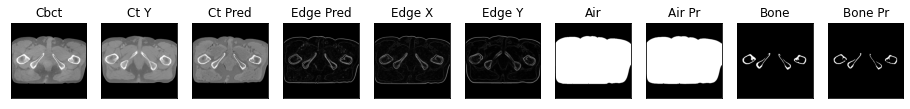

115it [00:55,  2.22it/s]

ssim score = 0.7189399003982544
psnr score = 20.19971466064453
snr score = 12.246522903442383
mae error = 0.04776911064982414
air dice score = 0.9966800933288468
bone dice score = 0.8250897175873757
contour dice score = 0.3522522449493408


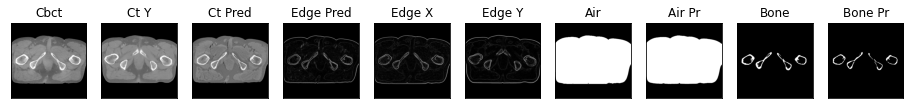

116it [00:56,  2.28it/s]

ssim score = 0.7118942141532898
psnr score = 19.90846824645996
snr score = 11.994348526000977
mae error = 0.04868965595960617
air dice score = 0.9961580139887718
bone dice score = 0.8330762110485487
contour dice score = 0.3730941712856293


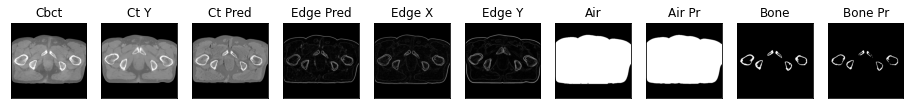

117it [00:56,  2.25it/s]

ssim score = 0.7014071345329285
psnr score = 19.760772705078125
snr score = 11.895332336425781
mae error = 0.04955282062292099
air dice score = 0.9956129929587693
bone dice score = 0.8372508182112876
contour dice score = 0.380538672208786


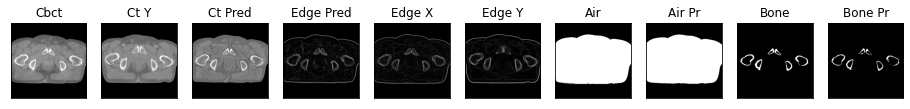

118it [00:57,  2.32it/s]

ssim score = 0.6936505436897278
psnr score = 19.541919708251953
snr score = 11.699094772338867
mae error = 0.05119059234857559
air dice score = 0.9957663193619967
bone dice score = 0.825539307950984
contour dice score = 0.4071398079395294


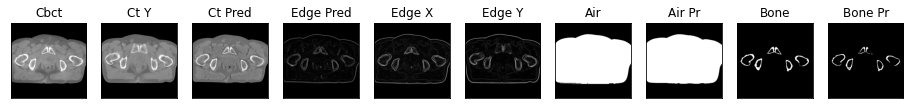

119it [00:57,  1.96it/s]

ssim score = 0.6869759559631348
psnr score = 19.56931495666504
snr score = 11.769264221191406
mae error = 0.05221940949559212
air dice score = 0.9963607375571905
bone dice score = 0.8012687905143943
contour dice score = 0.41549596190452576


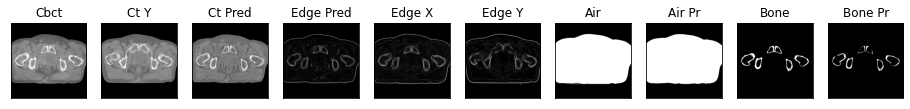

120it [00:58,  2.02it/s]

ssim score = 0.6919096112251282
psnr score = 19.550996780395508
snr score = 11.809287071228027
mae error = 0.05309831351041794
air dice score = 0.9966143074301
bone dice score = 0.7712401396641505
contour dice score = 0.3840217888355255


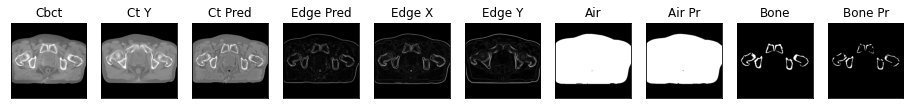

121it [00:58,  2.07it/s]

ssim score = 0.6828219890594482
psnr score = 19.568622589111328
snr score = 11.75153923034668
mae error = 0.05327330157160759
air dice score = 0.9971526687259503
bone dice score = 0.7175925925960331
contour dice score = 0.41404467821121216


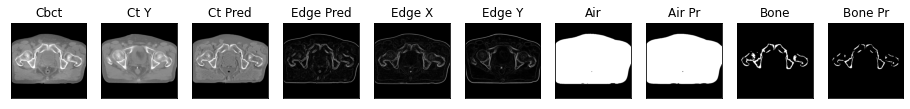

122it [00:59,  2.19it/s]

ssim score = 0.6861171722412109
psnr score = 19.760093688964844
snr score = 11.835794448852539
mae error = 0.05186564102768898
air dice score = 0.9971414932103291
bone dice score = 0.6977248104045055
contour dice score = 0.42268985509872437


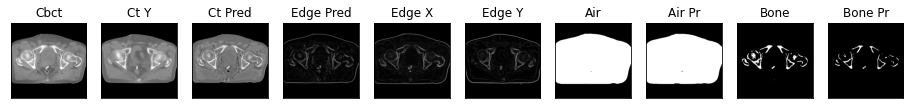

123it [00:59,  2.21it/s]

ssim score = 0.694256603717804
psnr score = 20.184009552001953
snr score = 12.136621475219727
mae error = 0.048628807067871094
air dice score = 0.9975188389778322
bone dice score = 0.6386277001316566
contour dice score = 0.43709826469421387


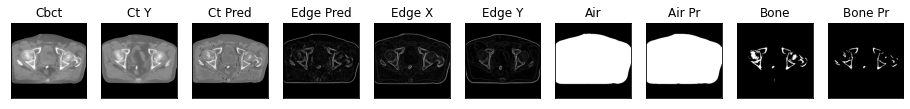

124it [00:59,  2.26it/s]

ssim score = 0.7085192799568176
psnr score = 20.510818481445312
snr score = 12.350998878479004
mae error = 0.0463753417134285
air dice score = 0.9978014114822885
bone dice score = 0.6633689143496047
contour dice score = 0.4516128897666931


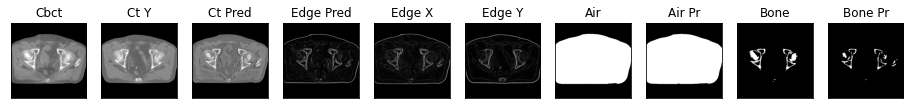

125it [01:00,  2.25it/s]

ssim score = 0.7048019766807556
psnr score = 20.550439834594727
snr score = 12.339974403381348
mae error = 0.04613437131047249
air dice score = 0.9978187288454319
bone dice score = 0.6923076923116769
contour dice score = 0.4712963104248047


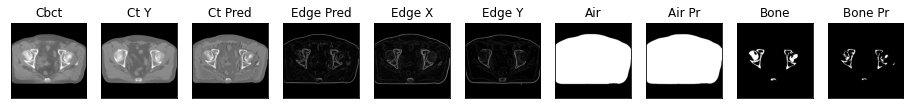

126it [01:00,  2.33it/s]

ssim score = 0.7086544036865234
psnr score = 20.4289608001709
snr score = 12.250648498535156
mae error = 0.04680132120847702
air dice score = 0.998037963661695
bone dice score = 0.7356598475767394
contour dice score = 0.5006979703903198


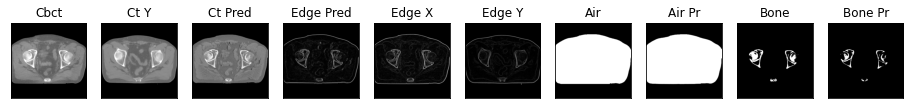

127it [01:01,  2.32it/s]

ssim score = 0.7065410017967224
psnr score = 20.20675277709961
snr score = 12.041916847229004
mae error = 0.047356124967336655
air dice score = 0.9976691063353703
bone dice score = 0.7410496046047297
contour dice score = 0.4265668988227844


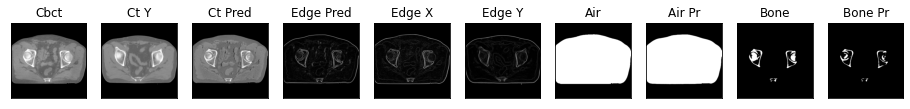

128it [01:01,  2.32it/s]

ssim score = 0.7116720080375671
psnr score = 20.241594314575195
snr score = 11.935267448425293
mae error = 0.047071658074855804
air dice score = 0.9973992807019615
bone dice score = 0.7920274914117934
contour dice score = 0.42284095287323


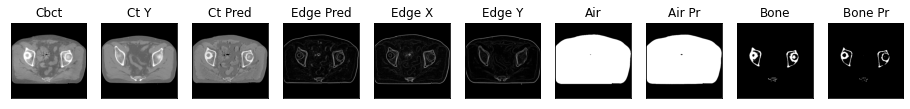

129it [01:02,  1.94it/s]

ssim score = 0.718919038772583
psnr score = 20.40793228149414
snr score = 12.04229736328125
mae error = 0.04568390175700188
air dice score = 0.9969744416844255
bone dice score = 0.8297443842009334
contour dice score = 0.39659252762794495


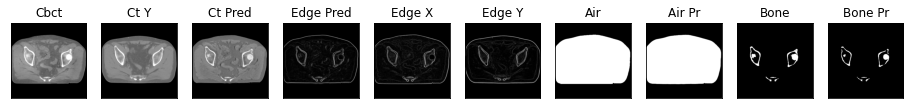

130it [01:02,  2.03it/s]

ssim score = 0.7204739451408386
psnr score = 20.591516494750977
snr score = 12.251530647277832
mae error = 0.04468296468257904
air dice score = 0.9970248129417697
bone dice score = 0.8587200981423283
contour dice score = 0.3958333432674408


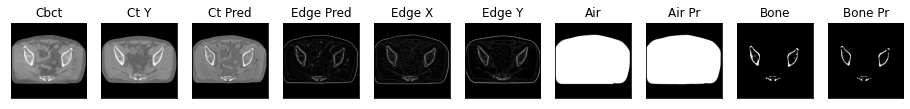

131it [01:03,  2.08it/s]

ssim score = 0.7160570621490479
psnr score = 20.372177124023438
snr score = 12.105005264282227
mae error = 0.04618364945054054
air dice score = 0.9966113786338525
bone dice score = 0.8584633160050363
contour dice score = 0.39507341384887695


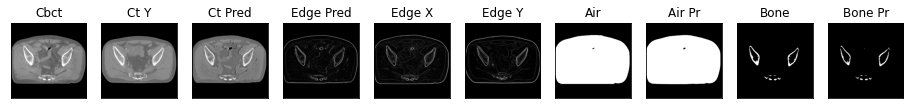

132it [01:03,  2.15it/s]

ssim score = 0.7130502462387085
psnr score = 19.954612731933594
snr score = 11.816671371459961
mae error = 0.04851103574037552
air dice score = 0.9962248347243434
bone dice score = 0.8505079825861664
contour dice score = 0.4198473393917084


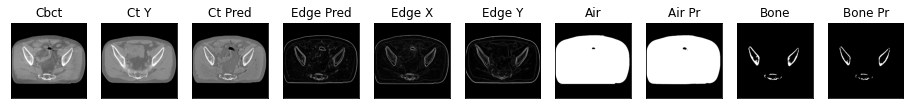

133it [01:04,  2.17it/s]

ssim score = 0.7102521061897278
psnr score = 19.90142059326172
snr score = 11.79743766784668
mae error = 0.048677075654268265
air dice score = 0.9961551652556928
bone dice score = 0.830252100843189
contour dice score = 0.39462313055992126


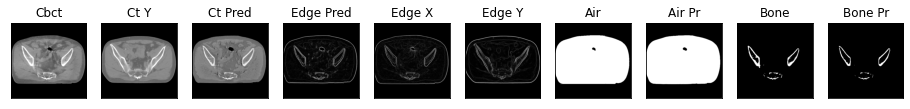

134it [01:04,  2.25it/s]

ssim score = 0.7015354037284851
psnr score = 20.041837692260742
snr score = 11.908063888549805
mae error = 0.048779912292957306
air dice score = 0.9962640400272826
bone dice score = 0.7759828448924091
contour dice score = 0.3668752908706665


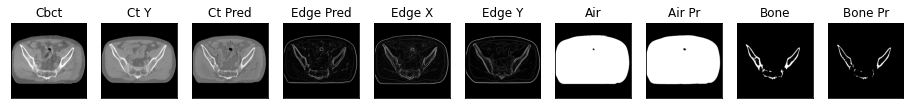

135it [01:04,  2.25it/s]

ssim score = 0.6998418569564819
psnr score = 20.247575759887695
snr score = 12.05042839050293
mae error = 0.047637369483709335
air dice score = 0.9965368594400873
bone dice score = 0.7897125567354053
contour dice score = 0.3558994233608246


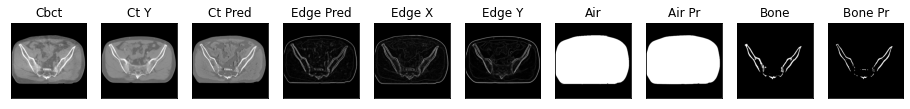

136it [01:05,  2.25it/s]

ssim score = 0.7798762917518616
psnr score = 21.26384735107422
snr score = 12.74123764038086
mae error = 0.03633524477481842
air dice score = 0.9983612999859128
bone dice score = 0.7853299348656849
contour dice score = 0.5661136507987976


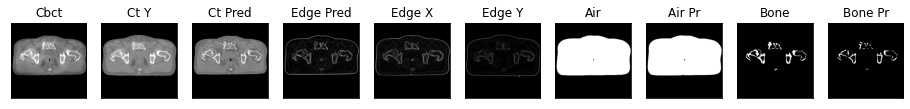

137it [01:05,  2.28it/s]

ssim score = 0.7853159308433533
psnr score = 21.32419776916504
snr score = 12.841602325439453
mae error = 0.03639461100101471
air dice score = 0.9987966841964533
bone dice score = 0.7796410709064483
contour dice score = 0.5738779902458191


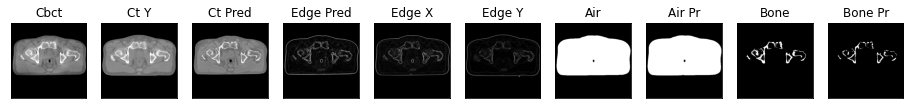

138it [01:06,  2.26it/s]

ssim score = 0.7861914038658142
psnr score = 21.425586700439453
snr score = 12.950778007507324
mae error = 0.03643341362476349
air dice score = 0.9988029116757015
bone dice score = 0.796694214879088
contour dice score = 0.5265823006629944


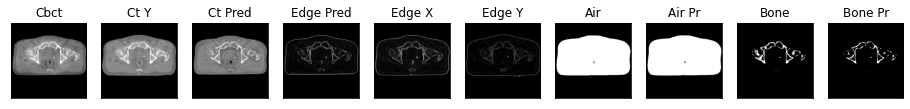

139it [01:06,  1.93it/s]

ssim score = 0.7901372313499451
psnr score = 21.51756477355957
snr score = 12.984334945678711
mae error = 0.0355084203183651
air dice score = 0.9984559267796015
bone dice score = 0.7527521570997805
contour dice score = 0.5647537112236023


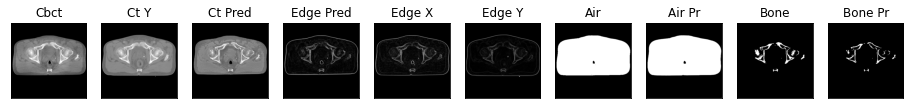

140it [01:07,  2.01it/s]

ssim score = 0.7954485416412354
psnr score = 21.82244873046875
snr score = 13.133593559265137
mae error = 0.03262113407254219
air dice score = 0.9983015211486818
bone dice score = 0.7714737396843233
contour dice score = 0.5712831020355225


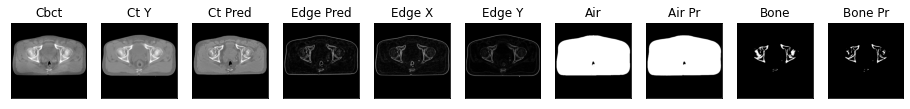

141it [01:07,  2.11it/s]

ssim score = 0.8001295328140259
psnr score = 21.92276954650879
snr score = 13.213111877441406
mae error = 0.03201416879892349
air dice score = 0.9980950952452392
bone dice score = 0.7923728813593159
contour dice score = 0.5965270400047302


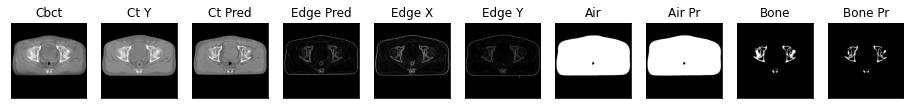

142it [01:08,  2.14it/s]

ssim score = 0.7943216562271118
psnr score = 21.842506408691406
snr score = 13.117219924926758
mae error = 0.03192891553044319
air dice score = 0.9978262014186121
bone dice score = 0.7824817518283458
contour dice score = 0.6010256409645081


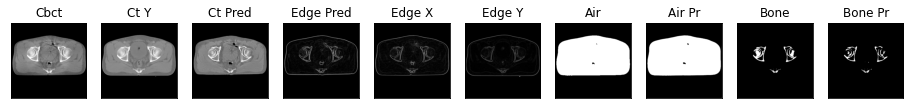

143it [01:08,  2.20it/s]

ssim score = 0.7912295460700989
psnr score = 21.368959426879883
snr score = 12.653036117553711
mae error = 0.03361976519227028
air dice score = 0.998103499081974
bone dice score = 0.7715786019072599
contour dice score = 0.5823045372962952


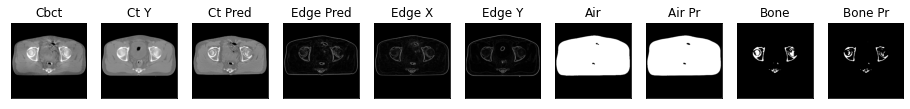

144it [01:09,  2.23it/s]

ssim score = 0.7858989238739014
psnr score = 21.174936294555664
snr score = 12.514792442321777
mae error = 0.035122890025377274
air dice score = 0.9979486325478605
bone dice score = 0.7977207977239994
contour dice score = 0.5653746724128723


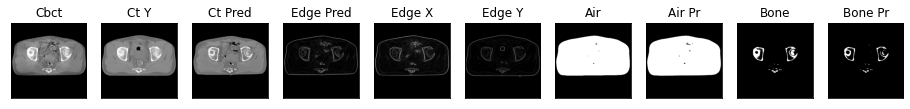

145it [01:09,  2.24it/s]

ssim score = 0.787419319152832
psnr score = 21.121849060058594
snr score = 12.439779281616211
mae error = 0.03555440530180931
air dice score = 0.9977412215656318
bone dice score = 0.7931090524980805
contour dice score = 0.5746887922286987


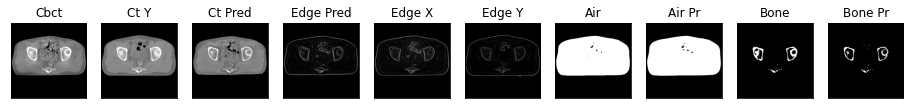

146it [01:10,  2.26it/s]

ssim score = 0.7859715819358826
psnr score = 20.838462829589844
snr score = 12.08561897277832
mae error = 0.03602031618356705
air dice score = 0.9974739958942913
bone dice score = 0.7970165157201737
contour dice score = 0.5717266798019409


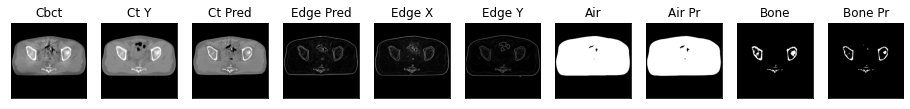

147it [01:10,  2.24it/s]

ssim score = 0.789707362651825
psnr score = 21.04412269592285
snr score = 12.247382164001465
mae error = 0.034896623343229294
air dice score = 0.9971660135511934
bone dice score = 0.8253792082903185
contour dice score = 0.5709795951843262


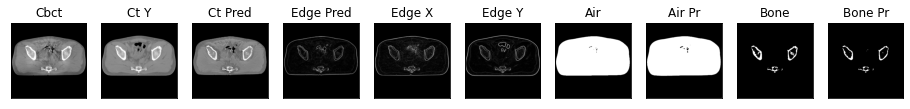

148it [01:10,  2.31it/s]

ssim score = 0.789482057094574
psnr score = 21.135570526123047
snr score = 12.337736129760742
mae error = 0.034161679446697235
air dice score = 0.9973709423983464
bone dice score = 0.8327351040948899
contour dice score = 0.6017885208129883


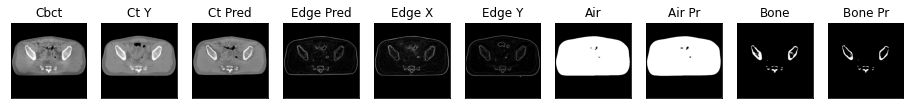

149it [01:11,  1.95it/s]

ssim score = 0.7838953137397766
psnr score = 20.89229393005371
snr score = 12.10781478881836
mae error = 0.03557374328374863
air dice score = 0.9965259857804234
bone dice score = 0.8195592286532445
contour dice score = 0.5648050308227539


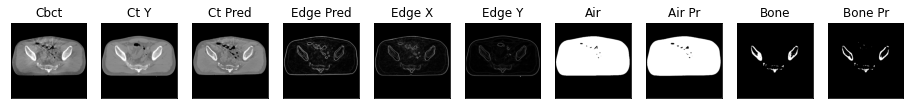

150it [01:12,  2.02it/s]

ssim score = 0.7847360372543335
psnr score = 20.825899124145508
snr score = 12.096625328063965
mae error = 0.036613497883081436
air dice score = 0.9969138905862085
bone dice score = 0.7848253111443271
contour dice score = 0.5846965909004211


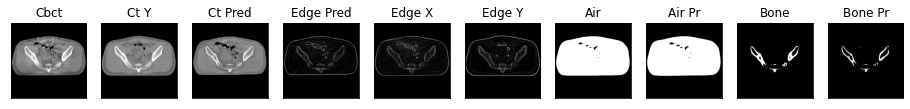

151it [01:12,  2.07it/s]

ssim score = 0.7855112552642822
psnr score = 20.51140785217285
snr score = 11.801504135131836
mae error = 0.038267962634563446
air dice score = 0.9965440823221314
bone dice score = 0.7984779299878466
contour dice score = 0.5986250638961792


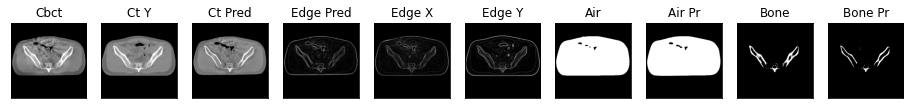

152it [01:12,  2.14it/s]

ssim score = 0.7903998494148254
psnr score = 20.564159393310547
snr score = 11.799516677856445
mae error = 0.03800681233406067
air dice score = 0.9966466602129745
bone dice score = 0.8082884646792579
contour dice score = 0.5493106842041016


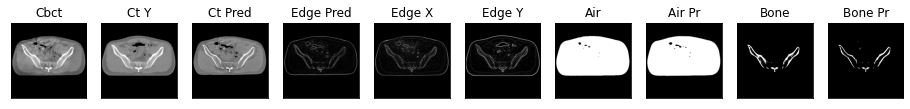

153it [01:13,  2.20it/s]

ssim score = 0.7941491007804871
psnr score = 20.843730926513672
snr score = 12.042734146118164
mae error = 0.03700299933552742
air dice score = 0.9974312948749711
bone dice score = 0.7973684210559643
contour dice score = 0.5327650308609009


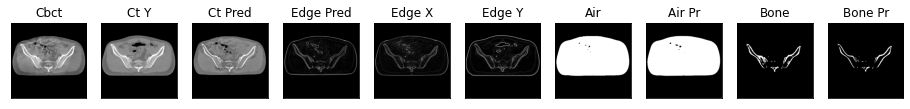

154it [01:13,  2.23it/s]

ssim score = 0.794579267501831
psnr score = 20.935335159301758
snr score = 12.13440990447998
mae error = 0.036540430039167404
air dice score = 0.9975683419809513
bone dice score = 0.7754423106037284
contour dice score = 0.5315508246421814


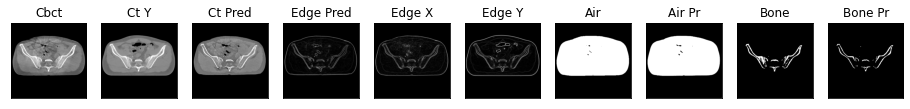

155it [01:14,  2.22it/s]

ssim score = 0.7913210391998291
psnr score = 20.886613845825195
snr score = 12.084266662597656
mae error = 0.03703784942626953
air dice score = 0.9976425336559358
bone dice score = 0.7833485262870958
contour dice score = 0.541644275188446


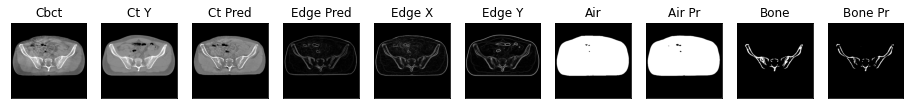

156it [01:14,  2.22it/s]

ssim score = 0.7863504886627197
psnr score = 20.428348541259766
snr score = 11.631040573120117
mae error = 0.03904295340180397
air dice score = 0.9968705237591106
bone dice score = 0.7823160471197442
contour dice score = 0.5259740352630615


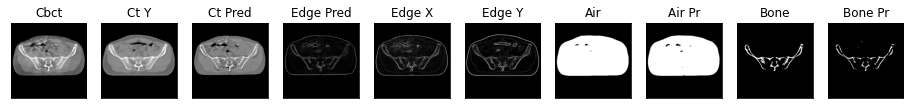

157it [01:15,  2.23it/s]

ssim score = 0.7801679372787476
psnr score = 20.07683753967285
snr score = 11.262259483337402
mae error = 0.04083016514778137
air dice score = 0.9959329881587418
bone dice score = 0.7603586889338225
contour dice score = 0.5636561512947083


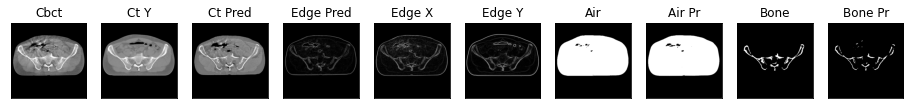

158it [01:15,  2.28it/s]

ssim score = 0.7717062830924988
psnr score = 19.92490005493164
snr score = 11.091695785522461
mae error = 0.04185977950692177
air dice score = 0.9961066281515933
bone dice score = 0.7333627148562749
contour dice score = 0.5478403568267822


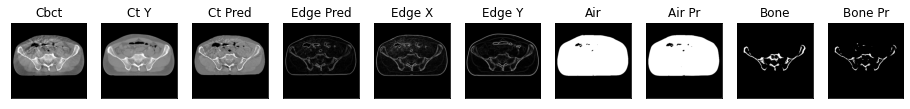

159it [01:16,  1.94it/s]

ssim score = 0.7666235566139221
psnr score = 19.870912551879883
snr score = 10.991771697998047
mae error = 0.042328353971242905
air dice score = 0.9960932577189697
bone dice score = 0.7226455787243329
contour dice score = 0.5303197503089905


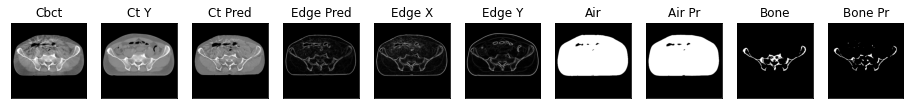

160it [01:16,  2.02it/s]

ssim score = 0.760895311832428
psnr score = 19.82518768310547
snr score = 10.892248153686523
mae error = 0.04270925000309944
air dice score = 0.9954039537072964
bone dice score = 0.7084337349438918
contour dice score = 0.5305216312408447


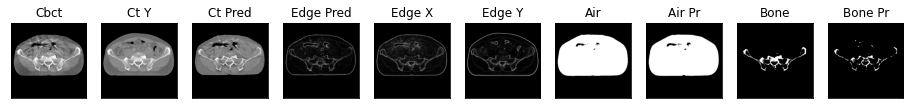

161it [01:17,  2.12it/s]

ssim score = 0.7548748850822449
psnr score = 19.64614486694336
snr score = 10.743666648864746
mae error = 0.04425914213061333
air dice score = 0.9953231326277044
bone dice score = 0.7716913234736547
contour dice score = 0.5353366732597351


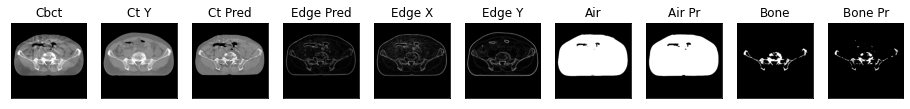

162it [01:17,  2.18it/s]

ssim score = 0.7509975433349609
psnr score = 19.532983779907227
snr score = 10.57528305053711
mae error = 0.044248245656490326
air dice score = 0.9960632113061422
bone dice score = 0.7691230036457114
contour dice score = 0.5391884446144104


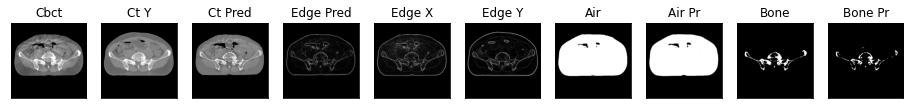

163it [01:17,  2.26it/s]

ssim score = 0.760072648525238
psnr score = 20.26012420654297
snr score = 11.154889106750488
mae error = 0.040093082934617996
air dice score = 0.9961378892967804
bone dice score = 0.8026410219635045
contour dice score = 0.49944135546684265


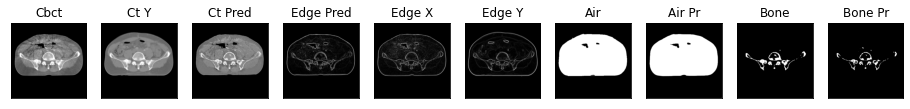

164it [01:18,  2.24it/s]

ssim score = 0.799770176410675
psnr score = 23.255104064941406
snr score = 13.636015892028809
mae error = 0.02894584648311138
air dice score = 0.9950786821477021
bone dice score = 0.9043778801870859
contour dice score = 0.5746123790740967


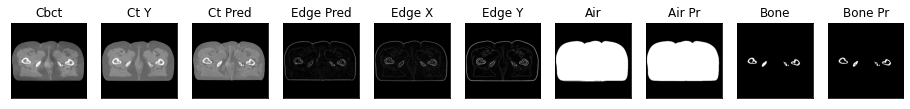

165it [01:18,  2.25it/s]

ssim score = 0.8033141493797302
psnr score = 23.31751823425293
snr score = 13.819442749023438
mae error = 0.02895803190767765
air dice score = 0.995698043634132
bone dice score = 0.898458527039431
contour dice score = 0.5635195374488831


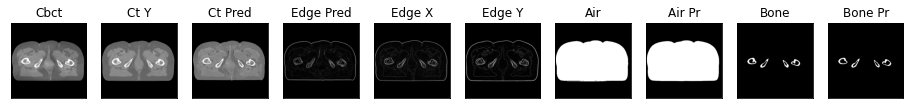

166it [01:19,  2.31it/s]

ssim score = 0.8009639382362366
psnr score = 23.22239112854004
snr score = 13.807231903076172
mae error = 0.029656635597348213
air dice score = 0.9958625102710122
bone dice score = 0.8820921985841735
contour dice score = 0.5436798334121704


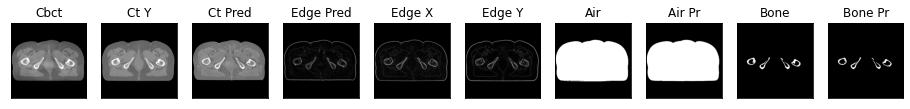

167it [01:19,  2.30it/s]

ssim score = 0.7975035905838013
psnr score = 23.084260940551758
snr score = 13.732548713684082
mae error = 0.03030119650065899
air dice score = 0.996026547583724
bone dice score = 0.876873228030035
contour dice score = 0.5446559190750122


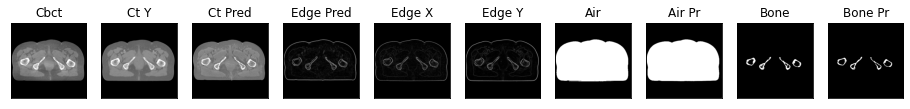

168it [01:20,  2.30it/s]

ssim score = 0.7982416152954102
psnr score = 22.98291015625
snr score = 13.65965747833252
mae error = 0.030892273411154747
air dice score = 0.9959673637813027
bone dice score = 0.8588908624460452
contour dice score = 0.5371372103691101


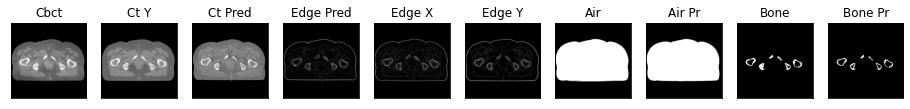

169it [01:20,  1.95it/s]

ssim score = 0.8010664582252502
psnr score = 22.927379608154297
snr score = 13.627081871032715
mae error = 0.030738050118088722
air dice score = 0.995999194082264
bone dice score = 0.858253221520592
contour dice score = 0.5498783588409424


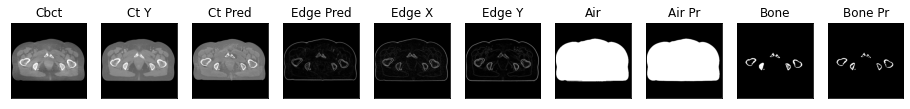

170it [01:21,  2.03it/s]

ssim score = 0.7983736395835876
psnr score = 22.887306213378906
snr score = 13.61833381652832
mae error = 0.03086891770362854
air dice score = 0.9958574741361391
bone dice score = 0.8493206246228083
contour dice score = 0.5188405513763428


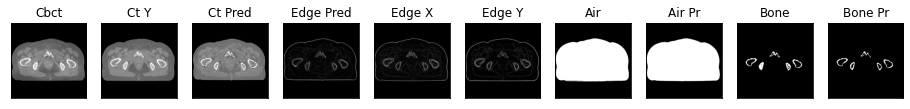

171it [01:21,  2.13it/s]

ssim score = 0.7967049479484558
psnr score = 22.595985412597656
snr score = 13.375378608703613
mae error = 0.031812507659196854
air dice score = 0.9956395140353174
bone dice score = 0.8741258741283192
contour dice score = 0.5366541147232056


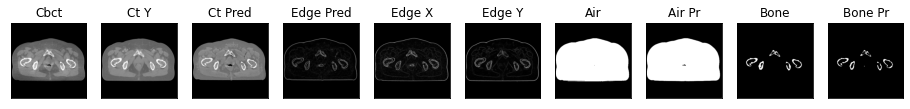

172it [01:22,  2.15it/s]

ssim score = 0.7961143851280212
psnr score = 22.52530860900879
snr score = 13.347445487976074
mae error = 0.031942639499902725
air dice score = 0.995817100382419
bone dice score = 0.8643820634366682
contour dice score = 0.5052833557128906


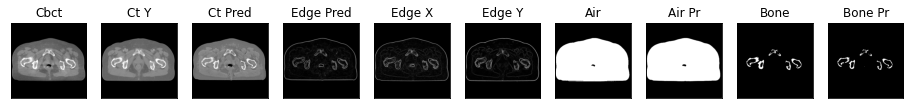

173it [01:22,  2.18it/s]

ssim score = 0.7953715324401855
psnr score = 22.374317169189453
snr score = 13.284158706665039
mae error = 0.03281932324171066
air dice score = 0.9953874075508817
bone dice score = 0.8424426991530303
contour dice score = 0.5408687591552734


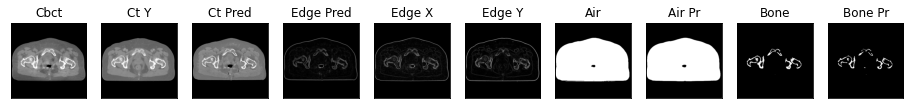

174it [01:22,  2.27it/s]

ssim score = 0.7988394498825073
psnr score = 22.79288101196289
snr score = 13.815994262695312
mae error = 0.03201386332511902
air dice score = 0.9949376307540753
bone dice score = 0.8165275687533653
contour dice score = 0.4831719696521759


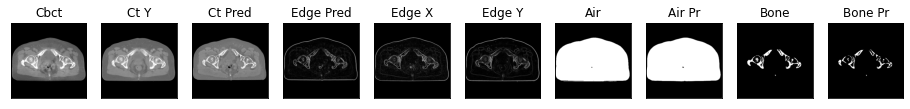

175it [01:23,  2.27it/s]

ssim score = 0.7988201379776001
psnr score = 22.60777473449707
snr score = 13.50233268737793
mae error = 0.031141439452767372
air dice score = 0.9948995285819582
bone dice score = 0.8493762800251466
contour dice score = 0.5055452585220337


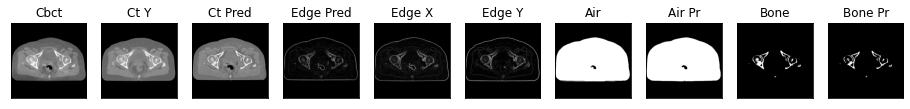

176it [01:23,  2.28it/s]

ssim score = 0.8017310500144958
psnr score = 22.892993927001953
snr score = 13.67813491821289
mae error = 0.02971557527780533
air dice score = 0.9949544759372847
bone dice score = 0.8542775276329456
contour dice score = 0.507239580154419


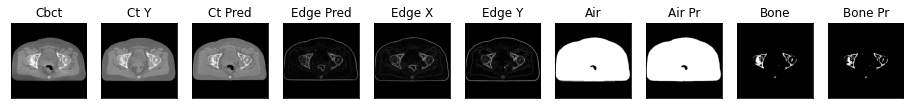

177it [01:24,  2.28it/s]

ssim score = 0.801338255405426
psnr score = 22.911190032958984
snr score = 13.66920280456543
mae error = 0.03036205656826496
air dice score = 0.9950350113617781
bone dice score = 0.8347692896834239
contour dice score = 0.5249656438827515


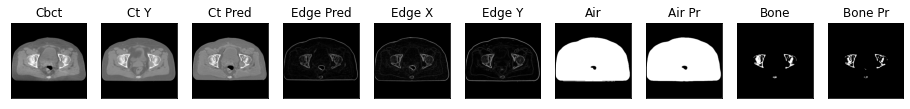

178it [01:24,  2.35it/s]

ssim score = 0.8069164752960205
psnr score = 23.270484924316406
snr score = 14.02049446105957
mae error = 0.030102994292974472
air dice score = 0.9954374020030261
bone dice score = 0.8288800454836294
contour dice score = 0.5336448550224304


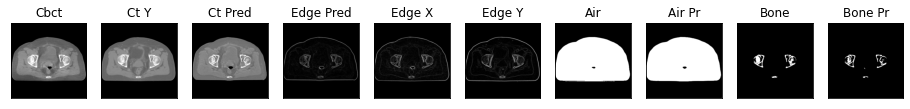

179it [01:25,  1.98it/s]

ssim score = 0.7999317646026611
psnr score = 23.51488494873047
snr score = 14.299123764038086
mae error = 0.030072225257754326
air dice score = 0.9958764763124945
bone dice score = 0.8464163822553186
contour dice score = 0.5242353081703186


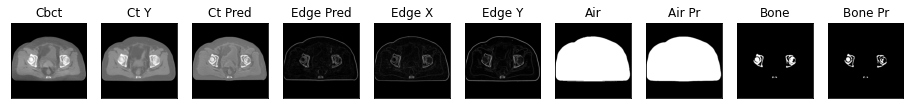

180it [01:25,  2.07it/s]

ssim score = 0.7995826005935669
psnr score = 23.22219467163086
snr score = 14.05792236328125
mae error = 0.03094479814171791
air dice score = 0.9966849907221461
bone dice score = 0.8787346221462436
contour dice score = 0.5437921285629272


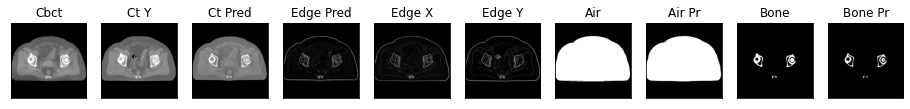

181it [01:26,  2.17it/s]

ssim score = 0.7883117198944092
psnr score = 22.68267822265625
snr score = 13.555961608886719
mae error = 0.032241325825452805
air dice score = 0.9967812415998699
bone dice score = 0.8800000000022749
contour dice score = 0.5516908168792725


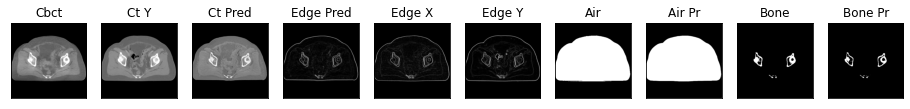

182it [01:26,  2.27it/s]

ssim score = 0.7706269025802612
psnr score = 21.59095573425293
snr score = 12.391803741455078
mae error = 0.03586375340819359
air dice score = 0.9962433026091624
bone dice score = 0.8821437040578102
contour dice score = 0.5522971749305725


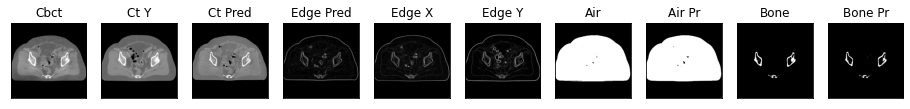

183it [01:27,  2.27it/s]

ssim score = 0.7602981328964233
psnr score = 21.405393600463867
snr score = 12.188249588012695
mae error = 0.036924656480550766
air dice score = 0.9962922900041524
bone dice score = 0.8887323943688091
contour dice score = 0.5652173757553101


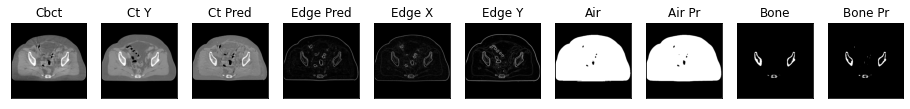

184it [01:27,  2.32it/s]

ssim score = 0.7583773136138916
psnr score = 21.771631240844727
snr score = 12.619401931762695
mae error = 0.03615282475948334
air dice score = 0.9969977247330957
bone dice score = 0.8965517241402778
contour dice score = 0.5345849990844727


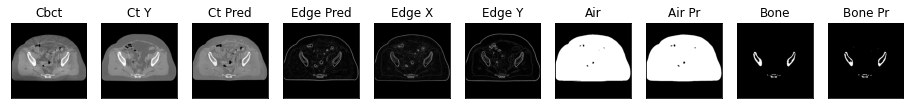

185it [01:27,  2.31it/s]

ssim score = 0.7591337561607361
psnr score = 21.846637725830078
snr score = 12.749502182006836
mae error = 0.03641436621546745
air dice score = 0.9965760053395651
bone dice score = 0.8735400724954986
contour dice score = 0.5385764241218567


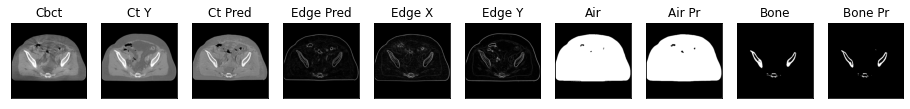

186it [01:28,  2.36it/s]

ssim score = 0.7593812942504883
psnr score = 21.27467155456543
snr score = 12.241966247558594
mae error = 0.03886513411998749
air dice score = 0.9967409483641962
bone dice score = 0.838530838533636
contour dice score = 0.531434178352356


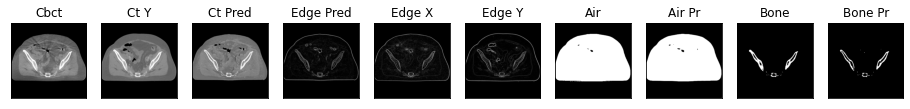

187it [01:28,  2.42it/s]

ssim score = 0.7524709105491638
psnr score = 21.113929748535156
snr score = 12.154084205627441
mae error = 0.03966046869754791
air dice score = 0.9968917217500808
bone dice score = 0.8085176625980767
contour dice score = 0.506403923034668


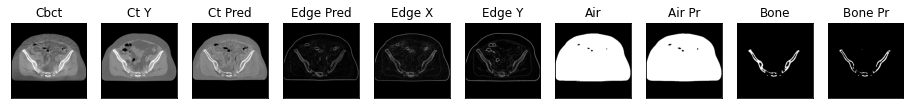

188it [01:29,  2.50it/s]

ssim score = 0.7504024505615234
psnr score = 21.007854461669922
snr score = 12.043720245361328
mae error = 0.039968278259038925
air dice score = 0.996577971504784
bone dice score = 0.8093333333365111
contour dice score = 0.49975597858428955


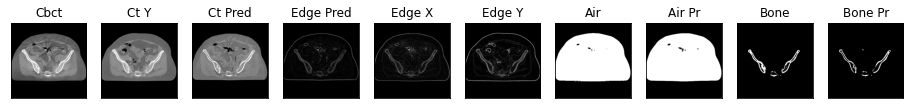

189it [01:29,  2.16it/s]

ssim score = 0.7493439316749573
psnr score = 21.146770477294922
snr score = 12.160457611083984
mae error = 0.03973376750946045
air dice score = 0.9969656949589325
bone dice score = 0.8119935170208753
contour dice score = 0.48155340552330017


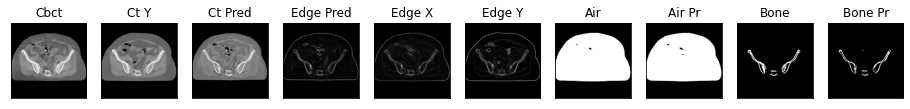

190it [01:30,  2.26it/s]

ssim score = 0.7519341707229614
psnr score = 21.6945858001709
snr score = 12.71990966796875
mae error = 0.037646904587745667
air dice score = 0.9970692836665259
bone dice score = 0.7996621621655462
contour dice score = 0.47830280661582947


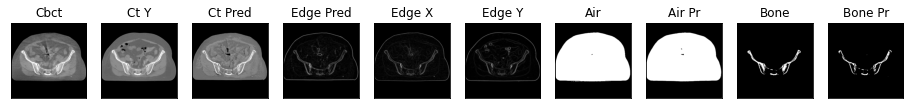

191it [01:30,  2.11it/s]


In [44]:
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=4)
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [45]:
tf_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(tf_discriminator)
replace_bn_to_instanceNorm(tf_discriminator)
tf_discriminator.load_state_dict(checkpoint["tf_discriminator"])

<All keys matched successfully>

In [46]:
edge_discriminator = Discriminator(in_channel=E_IN_CHANNELS, n_classes=E_N_CLASSES, activation=E_ACT)
replace_relu_to_leakyReLU(edge_discriminator)
replace_bn_to_instanceNorm(edge_discriminator)
edge_discriminator.load_state_dict(checkpoint["edge_discriminator"])

<All keys matched successfully>

In [47]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, \
#             score_air_test, score_bone_test, score_cont_test, score_tf_acc_test, score_edge_acc_test
eval_epoch(model, tf_discriminator, edge_discriminator, testloader, device)

191it [00:16, 11.35it/s]


(0.7924338448110051,
 21.847151931043694,
 12.851424017501751,
 0.034623028651972095,
 0.9963753269945922,
 0.8115561675031276,
 0.5100761179212501,
 72.0,
 71.99738219895288)

In [48]:
# import torchvision.models as models
# models.vgg16(pretrained=True)